# Experiments Theory of Mind in teacher-learner gridworld setup

In [1]:
from __future__ import annotations
import warnings

from minigrid.core.actions import Actions
from minigrid.core.constants import IDX_TO_COLOR, DIR_TO_VEC

import numpy as np
import pickle
import csv
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import progressbar

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.gridspec as gridspec

from environment import MultiGoalsEnv
from learner import BayesianLearner, BayesianLearnerPlanning
from bayesian_teacher import BayesianTeacherA_star, BayesianTeacher
from utils import *

warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.4.0 (SDL 2.26.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parameters

GRID_SIZE = 15
num_colors = 4
rf_values = [3, 5, 7] + [GRID_SIZE]

## Environment

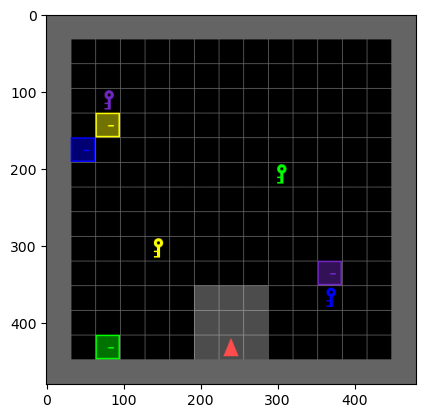

In [3]:
env = MultiGoalsEnv(render_mode = "rgb_array",
                    agent_goal=0, agent_view_size=3, 
                    agent_start_pos=(GRID_SIZE//2, GRID_SIZE-2), agent_start_dir=3,
                    size=GRID_SIZE)
_ = env.reset()

plt.imshow(env.render());

## Learner (Bayesian - RL)

In [4]:
receptive_field = 3
goal_color = 1

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE, save_render=True)
learner.play()

print(f' Learner with rf={receptive_field} for goal_color={goal_color} ({IDX_TO_COLOR[goal_color+1]}) \n \
      Step count: {learner.env.step_count} \n \
      Reward: {learner.reward:.4f}')

 Learner with rf=3 for goal_color=1 (blue) 
       Step count: 69 
       Reward: 0.6895


### Examples behaviours

In [30]:
from IPython.display import display, HTML

for rf in [3, 5, 7]:
    for goal in [1, 2, 3, 4]:
        gif_path = f"./outputs_rendering/example/output_rf_{rf}_goal_{goal}.gif"
        gif_beliefs_path = f"./outputs_rendering/example/output_belief_rf_{rf}_goal_{goal}.gif"
        title = f"Receptive field {rf}, goal {IDX_TO_COLOR[goal]}"

        html_code = f'''
        <div style="display: flex; justify-content;">
            <div>
                <h2>{title}</h2>
            </div>
        </div>
        <div style="display: flex; justify-content;">
            <div>
                <img src="{gif_path}" alt="GIF 1" width="300" height="300">
            </div>
            <div>
                <img src="{gif_beliefs_path}" alt="GIF 2" width="300" height="300">
            </div>
        </div>
        '''

        display(HTML(html_code))

### Statistics on different learners

In [21]:
# Paremeters

N = 500

In [22]:
mean_reward_all = np.zeros((num_colors, len(rf_values)))
std_reward_all = np.zeros((num_colors, len(rf_values)))

mean_count_all = np.zeros((num_colors, len(rf_values)))
std_count_all = np.zeros((num_colors, len(rf_values)))

for goal_color in range(num_colors):
    for ii,rf in enumerate(rf_values):
        rewards_all = []
        counts_all = []
        for _ in trange(N):
            learner = BayesianLearner(goal_color=goal_color, receptive_field=rf, grid_size=GRID_SIZE, max_steps=200)#, save_render=True)
            learner.play()
            
            if learner.reward == 0:
                assert(False)
            # Stats
            rewards_all.append(learner.reward)
            counts_all.append(learner.env.step_count)

        mean_reward_all[goal_color, ii] = np.mean(rewards_all)
        std_reward_all[goal_color, ii] = 1.96 * np.std(rewards_all) / np.sqrt(N)

        mean_count_all[goal_color, ii] = np.mean(counts_all)
        std_count_all[goal_color, ii] = 1.96 * np.std(counts_all) / np.sqrt(N)

100%|██████████| 500/500 [00:46<00:00, 10.78it/s]


In [23]:
import pandas as pd

mean_std_reward = np.zeros((num_colors, len(rf_values))).astype(str)

for goal in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_reward[goal, ii] = str(np.round(mean_reward_all[goal, ii], 4)) + " +/- " + str(np.round(std_reward_all[goal, ii], 4))

df_reward = pd.DataFrame(mean_std_reward, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

mean_std_count = np.zeros((num_colors, len(rf_values))).astype(str)

for goal in range(num_colors):
    for ii,rf in enumerate(rf_values):
        mean_std_count[goal, ii] = str(np.round(mean_count_all[goal, ii], 4)) + " +/- " + str(np.round(std_count_all[goal, ii], 4))

df_count = pd.DataFrame(mean_std_count, columns=np.array(rf_values).astype('str'), index=['Green', 'Blue', 'Purple', 'Yellow'])

In [24]:
print("Reward per type of learner")
display(df_reward)
print("# of step to fininsh the task per type of learner")
display(df_count)

Reward per type of learner


,3,5,7,15
Green,0.6986 +/- 0.0117,0.8055 +/- 0.0079,0.8608 +/- 0.0049,0.8958 +/- 0.0028
Blue,0.6808 +/- 0.0117,0.8096 +/- 0.0084,0.8606 +/- 0.0049,0.8947 +/- 0.0027
Purple,0.6939 +/- 0.012,0.8123 +/- 0.0079,0.8613 +/- 0.0049,0.8938 +/- 0.0025
Yellow,0.6999 +/- 0.012,0.8116 +/- 0.0081,0.8564 +/- 0.005,0.8966 +/- 0.0027


# of step to fininsh the task per type of learner


,3,5,7,15
Green,66.974 +/- 2.6003,43.228 +/- 1.7594,30.944 +/- 1.0872,23.158 +/- 0.6302
Blue,70.942 +/- 2.5946,42.316 +/- 1.8755,30.984 +/- 1.0925,23.4 +/- 0.6005
Purple,68.016 +/- 2.6755,41.71 +/- 1.7587,30.828 +/- 1.0811,23.61 +/- 0.5634
Yellow,66.692 +/- 2.6583,41.876 +/- 1.7889,31.904 +/- 1.1194,22.982 +/- 0.6018


In [25]:
import pandas as pd

mean_std_reward = np.zeros(len(rf_values)).astype(str)

for ii,rf in enumerate(rf_values):
    mean_std_reward[ii] = str(np.round(np.mean(mean_reward_all[:, ii]), 4)) + " +/- " + str(np.round(np.mean(std_reward_all[:, ii]), 4))

df_reward = pd.DataFrame(mean_std_reward.reshape((1,4)), columns=np.array(rf_values).astype('str'), index=['learner'])

mean_std_count = np.zeros(len(rf_values)).astype(str)

for ii,rf in enumerate(rf_values):
    mean_std_count[ii] = str(np.round(np.mean(mean_count_all[:, ii]), 4)) + " +/- " + str(np.round(np.mean(std_count_all[:, ii]), 4))

df_count = pd.DataFrame(mean_std_count.reshape((1,4)), columns=np.array(rf_values).astype('str'), index=['learner'])

In [26]:
print("Reward per RF")
display(df_reward)
print("# of step to fininsh the task per RF")
display(df_count)

Reward per RF


,3,5,7,15
learner,0.6933 +/- 0.0118,0.8097 +/- 0.0081,0.8598 +/- 0.0049,0.8952 +/- 0.0027


# of step to fininsh the task per RF


,3,5,7,15
learner,68.156 +/- 2.6322,42.2825 +/- 1.7956,31.165 +/- 1.0951,23.2875 +/- 0.599


## Bayesian teacher

### Teacher knowing exact policy of the learner

WARNING: bug when choosing a random exploratory goal (planning and NOT RL)

In [18]:
from minigrid.core.constants import DIR_TO_VEC

from environment import MultiGoalsEnv
from utils import *

import numpy as np
from queue import SimpleQueue

class BayesianTeacher:

    def __init__(self,
                 env: MultiGoalsEnv,
                 num_colors: int=4,
                 rf_values: np.ndarray=np.array([3,5,7,15]),
                 Na: int=6
                 ) -> None:
        
        self.env = env
        self.Na = Na

        self.num_colors = num_colors
        self.num_rf = len(rf_values)
        self.rf_values = rf_values
        self.gridsize = self.env.height

        self.beliefs = 1. / ( num_colors * len(rf_values)) * np.ones((num_colors, len(rf_values)))
        self.learner_beliefs = 1. / (2 + 2 * num_colors) * np.ones((len(rf_values), self.gridsize, self.gridsize, 2 + 2 * num_colors))

        self.learner_queue_actions = {}
        self.learner_queue_transitions = {}
        for goal_color in range(num_colors):
            self.learner_queue_actions[goal_color] = {}
            self.learner_queue_transitions[goal_color] = {}
            for rf in self.rf_values:
                self.learner_queue_actions[goal_color][rf] = SimpleQueue()
                self.learner_queue_transitions[goal_color][rf] = SimpleQueue()

        self.learner_going_to_subgoal = np.zeros((self.num_colors, self.num_rf), dtype=bool)
        self.learner_going_to_goal = np.zeros((self.num_colors, self.num_rf), dtype=bool)
        self.learner_reached_subgoal = np.zeros((self.num_colors, self.num_rf), dtype=bool)
        self.learner_step_count = -1

    def compute_learner_obs(self, receptive_field: int) -> np.ndarray:
        
        # Facing right
        if self.learner_dir == 0:
            topX = self.learner_pos[0]
            topY = self.learner_pos[1] - receptive_field // 2
        # Facing down
        elif self.learner_dir == 1:
            topX = self.learner_pos[0] - receptive_field // 2
            topY = self.learner_pos[1]
        # Facing left
        elif self.learner_dir == 2:
            topX = self.learner_pos[0] - receptive_field + 1
            topY = self.learner_pos[1] - receptive_field // 2
        # Facing up
        elif self.learner_dir == 3:
            topX = self.learner_pos[0] - receptive_field // 2
            topY = self.learner_pos[1] - receptive_field + 1
        
        grid = self.env.grid.slice(topX, topY, receptive_field, receptive_field)
        for i in range(self.learner_dir + 1):
            grid = grid.rotate_left()
        vis_mask = np.ones(shape=(grid.width, grid.height), dtype=bool)

        obs = grid.encode(vis_mask)

        return obs

    def update_learner_belief(self, rf_idx: int) -> None:
        
        receptive_field = self.rf_values[rf_idx]

        obs = self.compute_learner_obs(receptive_field)

        f_vec = DIR_TO_VEC[self.learner_dir]
        dir_vec = DIR_TO_VEC[self.learner_dir]
        dx, dy = dir_vec
        r_vec =  np.array((-dy, dx))
        top_left = (
            self.learner_pos
            + f_vec * (receptive_field - 1)
            - r_vec * (receptive_field // 2)
        )

        # For each cell in the visibility mask
        for vis_j in range(0, receptive_field):
            for vis_i in range(0, receptive_field):

                # Compute the world coordinates of this cell
                abs_i, abs_j = top_left - (f_vec * vis_j) + (r_vec * vis_i)
                if abs_i < 0 or abs_i >= self.gridsize:
                    continue
                if abs_j < 0 or abs_j >= self.gridsize:
                    continue

                one_hot = np.zeros(2 + 2 * self.num_colors)
                color_idx = obs[vis_i, vis_j, 1]

                if self.learner_pos == (abs_i, abs_j):
                    one_hot[0] = 1
                # Goal
                elif obs[vis_i, vis_j, 0] == 4:
                    one_hot[2 + (color_idx - 1) * 2] = 1
                # Subgoal (key)
                elif obs[vis_i, vis_j, 0] == 5:
                    one_hot[2 + (color_idx - 1) * 2 + 1] = 1
                # Wall
                elif obs[vis_i, vis_j, 0] == 2:
                    one_hot[1] = 1
                # Nothing
                else:
                    one_hot[0] = 1
                
                # print('update', 'pos', abs_i, abs_j, 'beliefs', one_hot)
                self.learner_beliefs[rf_idx, abs_i, abs_j, :] = one_hot

    def compute_exploration_score(self, dir: int, pos: tuple, rf_idx: int) -> float:
        
        receptive_field = self.rf_values[rf_idx]
        
        f_vec = DIR_TO_VEC[dir]
        dir_vec = DIR_TO_VEC[dir]
        dx, dy = dir_vec
        r_vec =  np.array((-dy, dx))

        top_left = (
            pos
            + f_vec * (receptive_field - 1)
            - r_vec * (receptive_field // 2)
        )

        exploration_score = 0

        # For each cell in the visibility mask
        for vis_j in range(0, receptive_field):
            for vis_i in range(0, receptive_field):

                # Compute the world coordinates of this cell
                abs_i, abs_j = top_left - (f_vec * vis_j) + (r_vec * vis_i)
                if abs_i < 0 or abs_i >= self.gridsize:
                    continue
                if abs_j < 0 or abs_j >= self.gridsize:
                    continue

                if Shannon_entropy(self.learner_beliefs[rf_idx, abs_i, abs_j, :]) > 0:
                    exploration_score += 1
            
        return exploration_score
    
    def learner_best_exploration_action(self,goal_color: int, rf_idx: int, forced: bool=False) -> int:

        receptive_field = self.rf_values[rf_idx]

        # Action that maximizes the exploration
        scores = np.zeros(3)
        # Turn left
        scores[0] = self.compute_exploration_score((self.learner_dir - 1) % 4, self.learner_pos, rf_idx=rf_idx)
        # Turn right
        scores[1] = self.compute_exploration_score((self.learner_dir + 1) % 4, self.learner_pos, rf_idx=rf_idx)
        # Move forward
        next_pos = self.learner_pos + DIR_TO_VEC[self.learner_dir]
        one_hot_empty = np.zeros(2 + self.num_colors * 2)
        one_hot_empty[0] = 1
        one_hot_subgoal = np.zeros(2 + self.num_colors * 2)
        one_hot_subgoal [2 + 2 * goal_color + 1]

        if not (np.all(self.learner_beliefs[rf_idx, next_pos[0], next_pos[1], :] == one_hot_empty) or \
            np.all(self.learner_beliefs[rf_idx, next_pos[0], next_pos[1], :] == one_hot_subgoal)): # Obstacle in front
            scores[2] = 0.
        else:
            scores[2] = self.compute_exploration_score(self.learner_dir, next_pos, rf_idx=rf_idx)

        argmax_set = np.where(np.isclose(scores, np.max(scores)))[0]

        # If actions better than the others
        if len(argmax_set) < 3 or forced:
          
            proba_dist = np.zeros(self.Na)
            proba_dist[argmax_set] = 1
            proba_dist /= proba_dist.sum()

            return proba_dist
        
        # If all the actions are equal
        else:
            
            print('CHOOSE EXPLORATORY GOAL')

            # Unexplored locations
            unexplored_pos = np.where(Shannon_entropy(self.learner_beliefs[rf_idx, ...], axis=2) != 0)

            # At least one unexplored position
            if len(unexplored_pos[0]) > 0:
                # Manhattan distance to the unexplored locations
                dist = np.array([Manhattan_dist(self.learner_pos, pos) for pos in zip(unexplored_pos[0], unexplored_pos[1])])
                # Closest unexplored locations
                argmin_set = np.where(np.isclose(dist, np.min(dist)))[0]
                # dest_idx = np.random.choice(argmin_set)
                dest_idx = argmin_set[0]
                dest_pos = (unexplored_pos[0][dest_idx], unexplored_pos[1][dest_idx])

                # Obstacles grid
                one_hot_empty = np.zeros(2 + self.num_colors * 2)
                one_hot_empty[0] = 1
                grid = np.ones((self.gridsize, self.gridsize)) - np.all(self.learner_beliefs[rf_idx, ...] == one_hot_empty.reshape(1, 1, -1), axis=2)
                grid[dest_pos[0], dest_pos[1]] = 0
                
                # If the intermediate exploratory goal is not reacheable change exploratory goal
                while dist[dest_idx] < 10e5:

                    path = A_star_algorithm(self.learner_pos, dest_pos, grid)

                    if path is None:
                        # Choose another exploratory goal
                        dist[dest_idx] = 10e5
                        argmin_set = np.where(np.isclose(dist, np.min(dist)))[0]
                        dest_idx = np.random.choice(argmin_set)
                        dest_pos = (unexplored_pos[0][dest_idx], unexplored_pos[1][dest_idx])

                        # Obstacles grid
                        one_hot_empty = np.zeros(2 + self.num_colors * 2)
                        one_hot_empty[0] = 1
                        grid = np.ones((self.gridsize, self.gridsize)) - np.all(self.learner_beliefs[rf_idx, ...] == one_hot_empty.reshape(1, 1, -1), axis=2)
                        grid[dest_pos[0], dest_pos[1]] = 0

                    else:
                        
                        print('TEACHED predicted dest pos', dest_pos, dist[dest_idx])
                        print('dist table', dist)

                        # Add transitions to go to exploratory goal
                        for transition in path:
                            self.learner_queue_transitions[goal_color][receptive_field].put(transition)

                        return self.learner_policy(goal_color, rf_idx)

            return self.learner_best_exploration_action(rf_idx, goal_color, forced=True)
            

    def add_actions(self, pos_dest: tuple, goal_color: int, rf_idx: int) -> None:
        
        receptive_field = self.rf_values[rf_idx]

        # Mapping position transition --> actions
        dx = self.learner_pos[0] - pos_dest[0]
        dy = self.learner_pos[1] - pos_dest[1]
        if dx < 0:
            if self.learner_dir == 0:
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 1:
                self.learner_queue_actions[goal_color][receptive_field].put(0)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 2:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 3:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)

        if dx > 0:
            if self.learner_dir == 0:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 1:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 2:
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 3:
                self.learner_queue_actions[goal_color][receptive_field].put(0)
                self.learner_queue_actions[goal_color][receptive_field].put(2)

        if dy < 0:
            if self.learner_dir == 0:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 1:
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 2:
                self.learner_queue_actions[goal_color][receptive_field].put(0)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 3:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)

        if dy > 0:
            if self.learner_dir == 0:
                self.learner_queue_actions[goal_color][receptive_field].put(0)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 1:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 2:
                self.learner_queue_actions[goal_color][receptive_field].put(1)
                self.learner_queue_actions[goal_color][receptive_field].put(2)
            elif self.learner_dir == 3:
                self.learner_queue_actions[goal_color][receptive_field].put(2)

    def obj_in_front(self, rf_idx: int, obj_idx: int) -> bool:

        dx, dy = 0, 0
        if self.learner_dir == 0:
            dx = 1
        elif self.learner_dir == 2:
            dx = -1
        elif self.learner_dir == 3:
            dy = -1
        elif self.learner_dir == 1:
            dy = 1

        return self.learner_beliefs[rf_idx, self.learner_pos[0] + dx, self.learner_pos[1] + dy, obj_idx] == 1
        
    def learner_policy(self, goal_color: int, rf_idx: int):

        receptive_field = self.rf_values[rf_idx]
            
        if self.learner_step_count == 0:
            proba_dist = np.zeros(self.Na)
            proba_dist[4] = 1 # unused (to get first observation)
            return proba_dist

        # Subgoal (key) in front of the learner
        if self.obj_in_front(rf_idx, obj_idx=2 + (goal_color * 2) + 1):
            self.learner_reached_subgoal[goal_color, rf_idx] = True
            self.learner_going_to_subgoal[goal_color, rf_idx] = False
            # Subgoal (key) reached --> empty queues
            while not self.learner_queue_transitions[goal_color][receptive_field].empty():
                _ = self.learner_queue_transitions[goal_color][receptive_field].get()
            while not self.learner_queue_actions[goal_color][receptive_field].empty():
                _ = self.learner_queue_actions[goal_color][receptive_field].get()
            proba_dist = np.zeros(self.Na)
            proba_dist[3] = 1 # Pickup the subgoal (key)
            return proba_dist
        
        # Goal (door) in front of the learner
        if self.obj_in_front(rf_idx, obj_idx= 2 + (2 * goal_color)) and self.learner_reached_subgoal[goal_color, rf_idx]:

            self.learner_going_to_goal[goal_color, rf_idx] = False
            # Goal (door) reached --> empty queues
            while not self.learner_queue_transitions[goal_color][receptive_field].empty():
                _ = self.learner_queue_transitions[goal_color][receptive_field].get()
            while not self.learner_queue_actions[goal_color][receptive_field].empty():
                _ = self.learner_queue_actions[goal_color][receptive_field].get()
            proba_dist = np.zeros(self.Na)
            proba_dist[5] = 1 # Open the goal (door)
            return proba_dist

        # If know where is the subgoal (key) & not already have subgoal (key) & not already going to the subgoal (key) --> go to the subgoal (key)
        if (self.learner_beliefs[rf_idx, :, :, 2 + goal_color * 2 + 1] == 1).any() and \
            not self.learner_reached_subgoal[goal_color, rf_idx] and \
            not self.learner_going_to_subgoal[goal_color, rf_idx]:
            
            subgoal_pos = np.where(self.learner_beliefs[rf_idx, :, :, 2 + goal_color * 2 + 1] == 1)
            # Obstacle grid # WARNING
            one_hot = np.zeros(2 + self.num_colors * 2)
            one_hot[0] = 1
            grid = np.ones((self.gridsize, self.gridsize)) - np.all(self.learner_beliefs[rf_idx, ...] == one_hot.reshape(1, 1, -1), axis=2)
            grid[subgoal_pos[0], subgoal_pos[1]] = 0
            
            path = A_star_algorithm(self.learner_pos, subgoal_pos, grid)

            if path is not None:
                # Empty queues
                while not self.learner_queue_transitions[goal_color][receptive_field].empty():
                    _ = self.learner_queue_transitions[goal_color][receptive_field].get()
                while not self.learner_queue_actions[goal_color][receptive_field].empty():
                    _ = self.learner_queue_actions[goal_color][receptive_field].get()
                # Add transitions to go to key
                for transition in path:
                    self.learner_queue_transitions[goal_color][receptive_field].put(transition)
                # Set variable
                self.learner_going_to_subgoal[goal_color, rf_idx] = True
                # Return action
                return self.learner_policy(goal_color, rf_idx)

        # If know where is the goal (door) & has subgoal (key) & not already going to the goal (door) --> go to the goal (door)
        elif (self.learner_beliefs[rf_idx, :, :, 2 + goal_color * 2] == 1).any() and \
              self.learner_reached_subgoal[goal_color, rf_idx] and \
              not self.learner_going_to_goal[goal_color, rf_idx]:

            goal_pos = np.where(self.learner_beliefs[rf_idx, :, :, 2 + goal_color * 2] == 1)
            # Obstacle grid
            one_hot = np.zeros(2 + self.num_colors * 2)
            one_hot[0] = 1
            grid = np.ones((self.gridsize, self.gridsize)) - np.all(self.learner_beliefs[rf_idx, ...] == one_hot.reshape(1, 1, -1), axis=2)
            grid[goal_pos[0], goal_pos[1]] = 0

            path = A_star_algorithm(self.learner_pos, goal_pos, grid)

            if path is not None:
                # Empty queues
                while not self.learner_queue_transitions[goal_color][receptive_field].empty():
                    _ = self.learner_queue_transitions[goal_color][receptive_field].get()
                while not self.learner_queue_actions[goal_color][receptive_field].empty():
                    _ = self.learner_queue_actions[goal_color][receptive_field].get()
                # Add transitions to go to goal (door)
                for transition in path:
                    self.learner_queue_transitions[goal_color][receptive_field].put(transition)
                # Set variable
                self.learner_going_to_goal[goal_color, rf_idx] = True
                # Return action
                return self.learner_policy(goal_color, rf_idx)
        
        # Action to be played
        if not self.learner_queue_actions[goal_color][receptive_field].empty():
            action = self.learner_queue_actions[goal_color][receptive_field].get()
            proba_dist = np.zeros(self.Na)
            proba_dist[action] = 1
            return proba_dist
        
        # Position to be reached
        if not self.learner_queue_transitions[goal_color][receptive_field].empty():
            _, pos_dest = self.learner_queue_transitions[goal_color][receptive_field].get()

            # If not an obstacle --> add action to reach pos_dest
            one_hot = np.zeros(2 + self.num_colors * 2)
            one_hot[0] = 1
            if np.any(self.learner_beliefs[rf_idx, pos_dest[0], pos_dest[1], :] == one_hot):
                self.add_actions(pos_dest=pos_dest, goal_color=goal_color, rf_idx=rf_idx)

            return self.learner_policy(goal_color, rf_idx)
        
        # Nothing to do 
        else:
            # Action that maximizes the exploration
            return self.learner_best_exploration_action(goal_color, rf_idx)
        
    def update_knowledge(self, learner_pos: tuple, learner_dir: int, learner_step_count: int) -> None:
        self.learner_pos = learner_pos
        self.learner_dir = learner_dir
        self.learner_step_count += 1
        assert(self.learner_step_count == learner_step_count)
        
        for rf_idx in range(self.num_rf):
            # Update what the learner knows about the env
            self.update_learner_belief(rf_idx)

    def observe(self, action: int) -> None:
        
        for rf_idx in range(self.num_rf):
            for goal_color in range(self.num_colors):
                # Predict policy of the learner
                predicted_policy = self.learner_policy(goal_color, rf_idx)
                
                # Bayesian update
                self.beliefs[goal_color, rf_idx] *= predicted_policy[action]

        self.beliefs /= self.beliefs.sum()

In [1049]:
receptive_field = 7
goal_color = 1

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE, save_render=True)

teacher = BayesianTeacher(env=learner.env)

True action 4
True action 0
True action 2
True action 1
True action 1
True action 2
CHOOSE EXPLORATORY GOAL
LEARNER CHOOSE EXPLORATORY GOAL
LEARNER dest pos (14, 13) 7
dist table [20 19 18 17 16 15 14 13 12 11 19 18 17 16 15 14 13 12 11 10 18 17 16 15
 14 13 12 11 10  9 17 16 15 14 13 12 11 16 15 14 13 12 11 10 15 14 13 12
 11 10  9 14 13 12 11 10  9  8 13 12 11 10  9  8  7 14 13 12 11 10  9  8
 15 14 13 12 11 10  9 16 15 14 13 12 11 10 17 16 15 14 13 12 11 10  9  8
 18 17 16 15 14 13 12 11 10  9 19 18 17 16 15 14 13 12 11 10 20 19 18 17
 16 15 14 13 12 11 10  9  8  7  8]
True action 0
CHOOSE EXPLORATORY GOAL
TEACHED predicted dest pos (7, 10) 3
dist table [20 19 18 17 16 15 14 13 12 11 10  9  8  7  8 19 18 17 16 15 14 13 12 11
 10  9  8  7  6  7 18 17 16 15 14 13 12 11 10  9  8  7  6  5  6 17 16 15
 14 13 12 11 10  9  8  7  6  5  4  5 16 15 14 13 12 11 10  9  8  7  6  5
 15 14 13 12 11 10  9  8  7  6  5 14 13 12 11 10  9  8  7  6  5  4 13 12
 11 10  9  8  7  6  5  4  3 14 13 12 11 10 

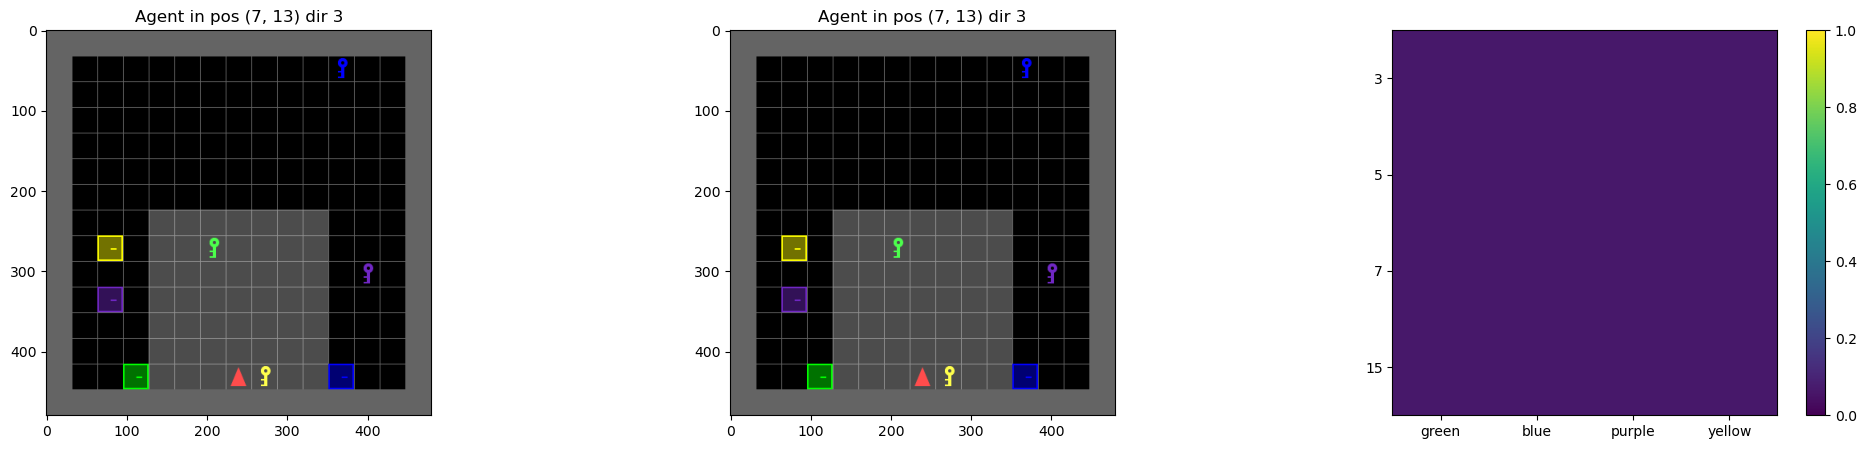

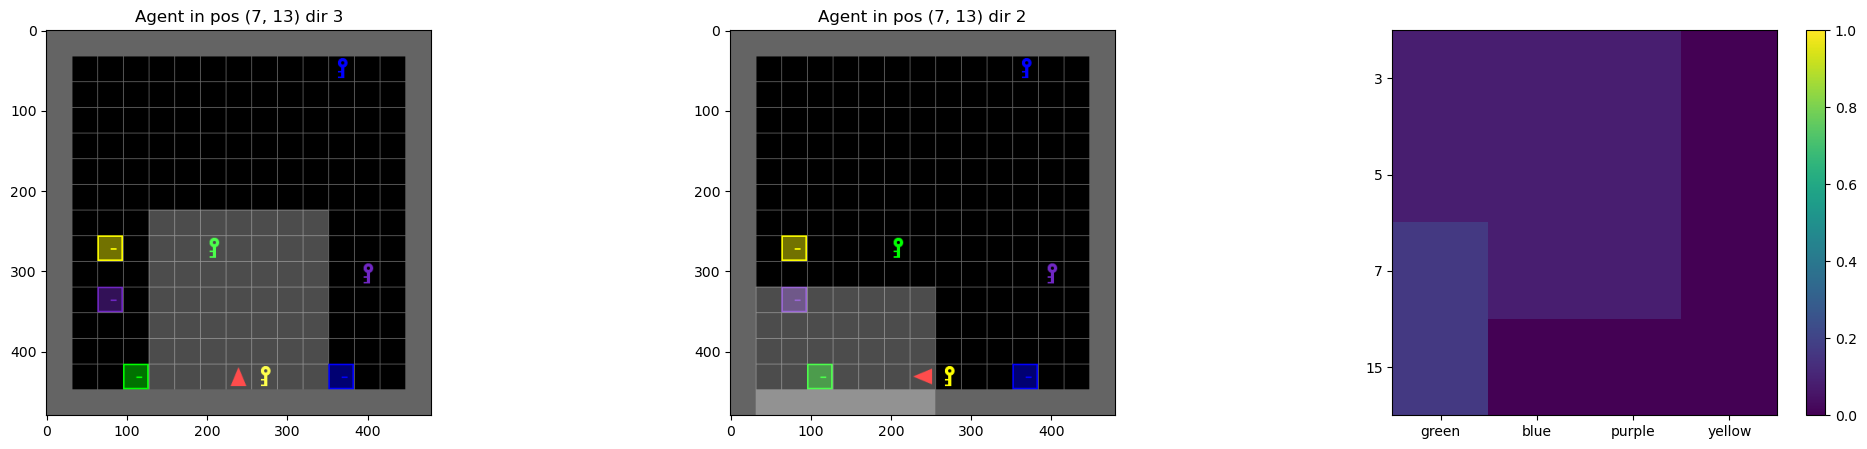

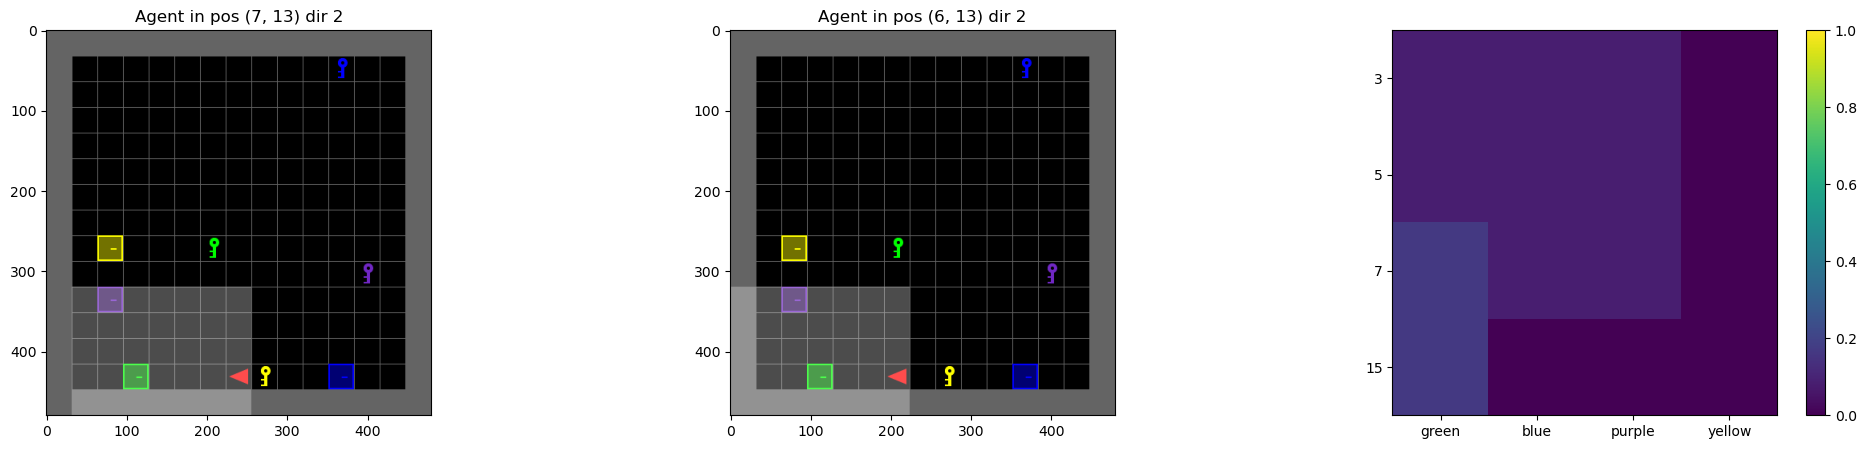

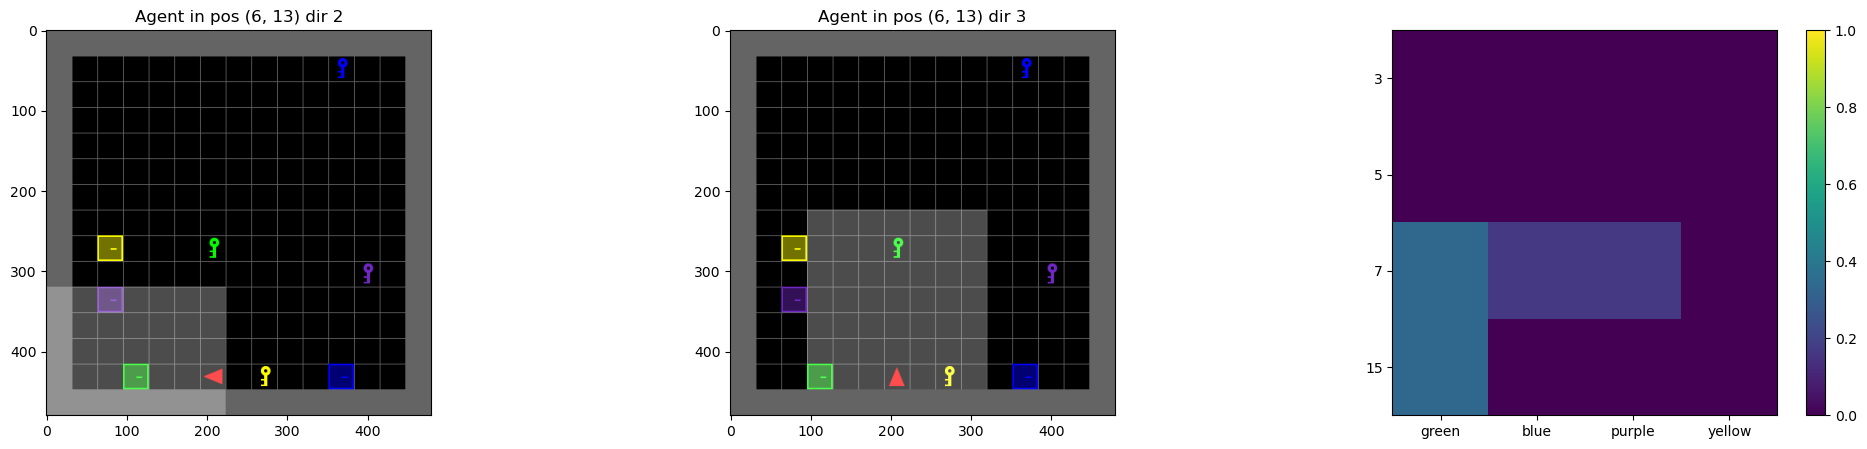

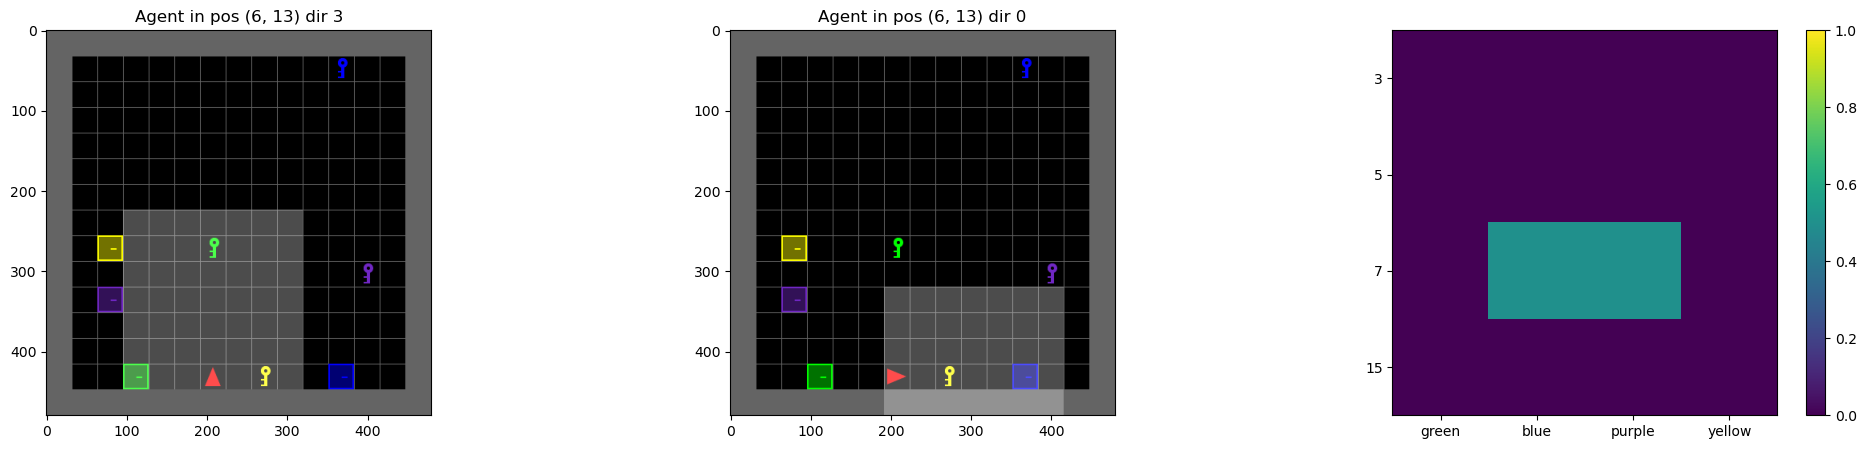

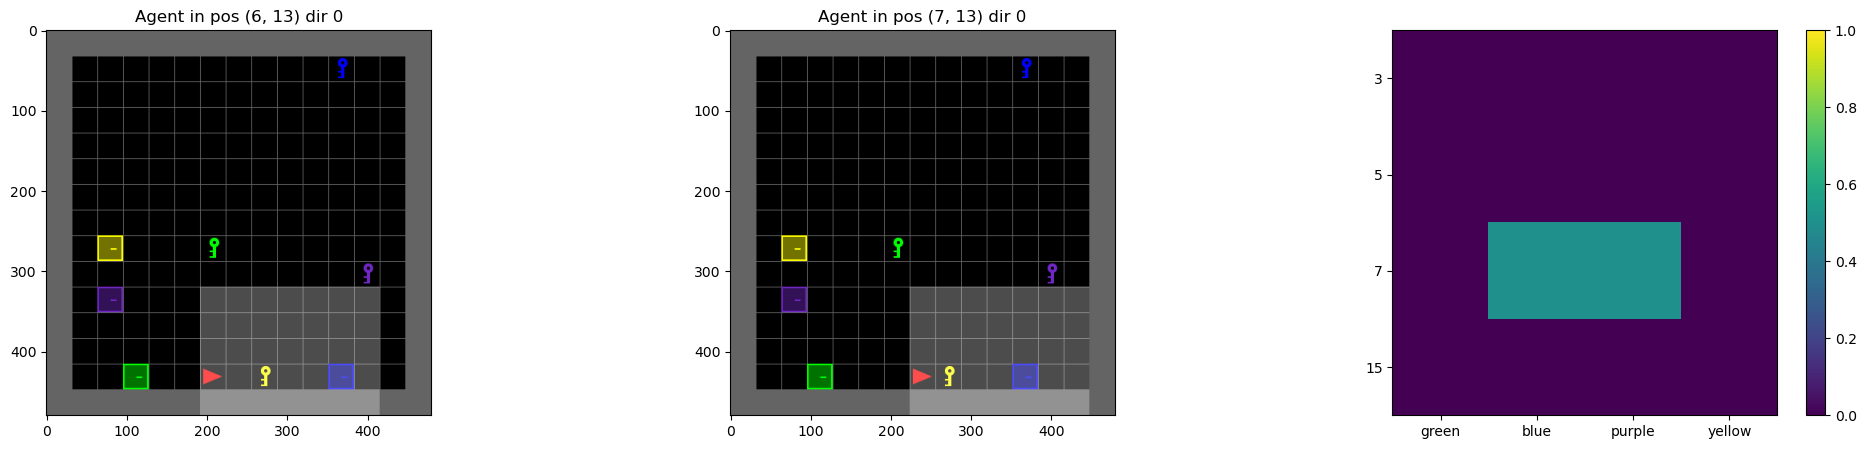

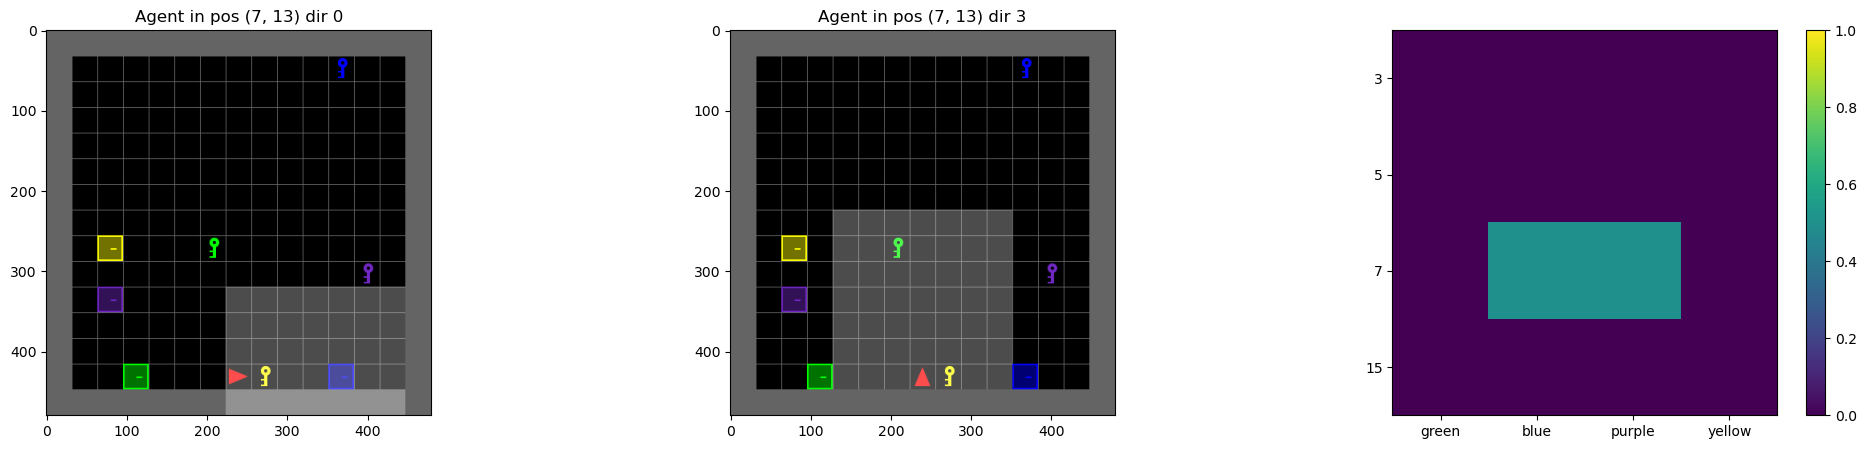

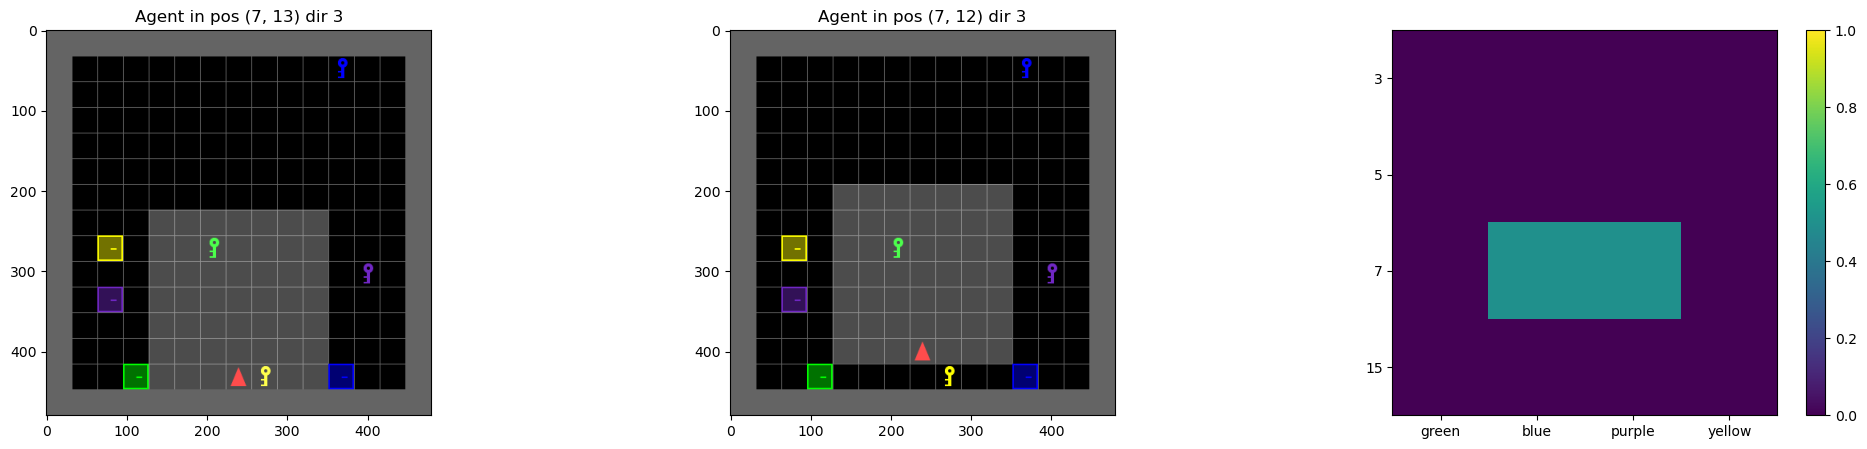

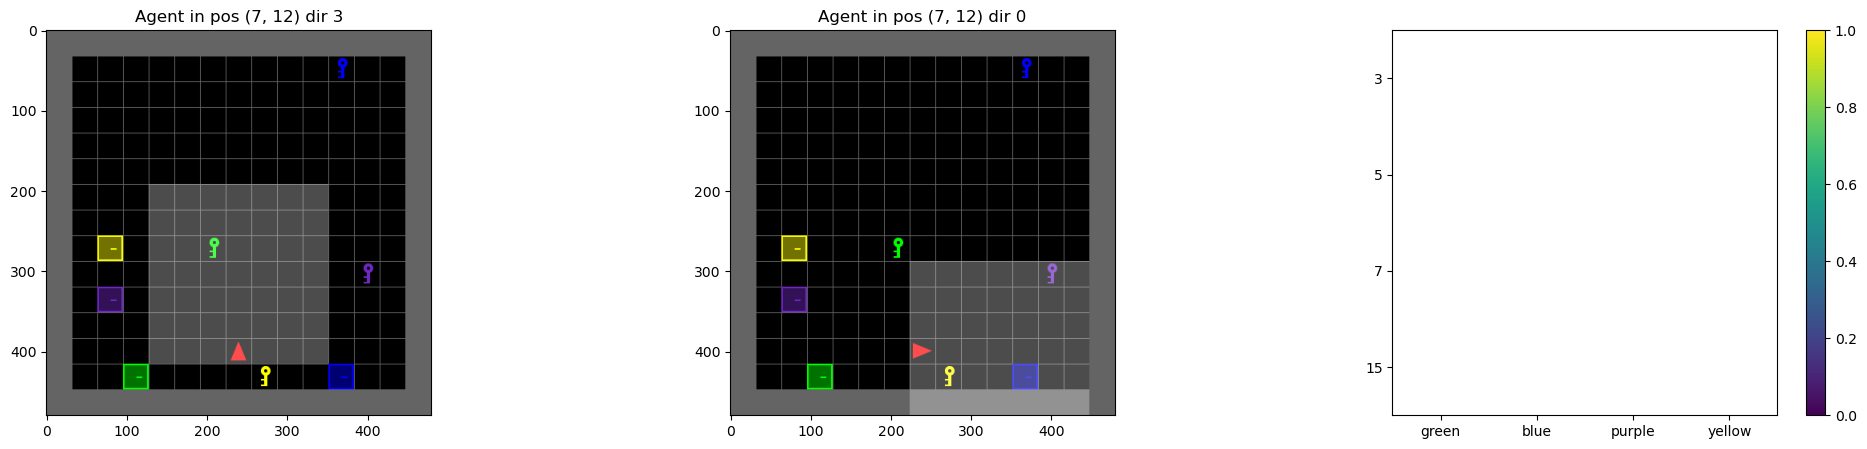

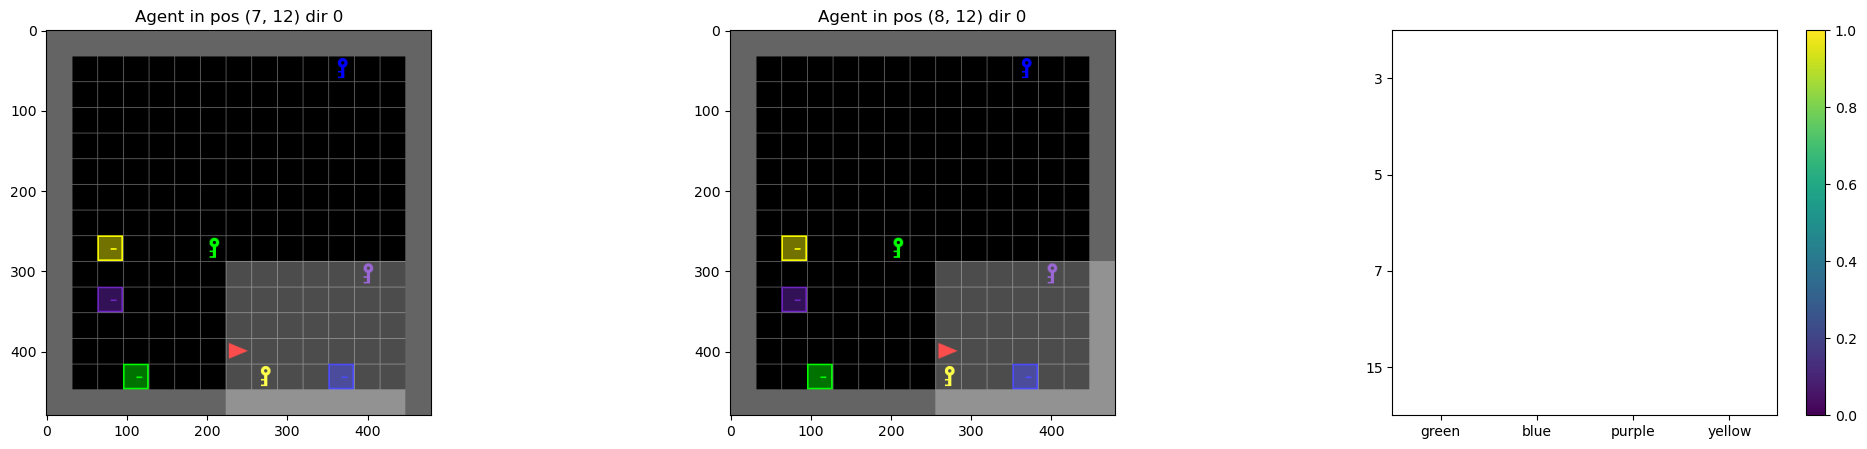

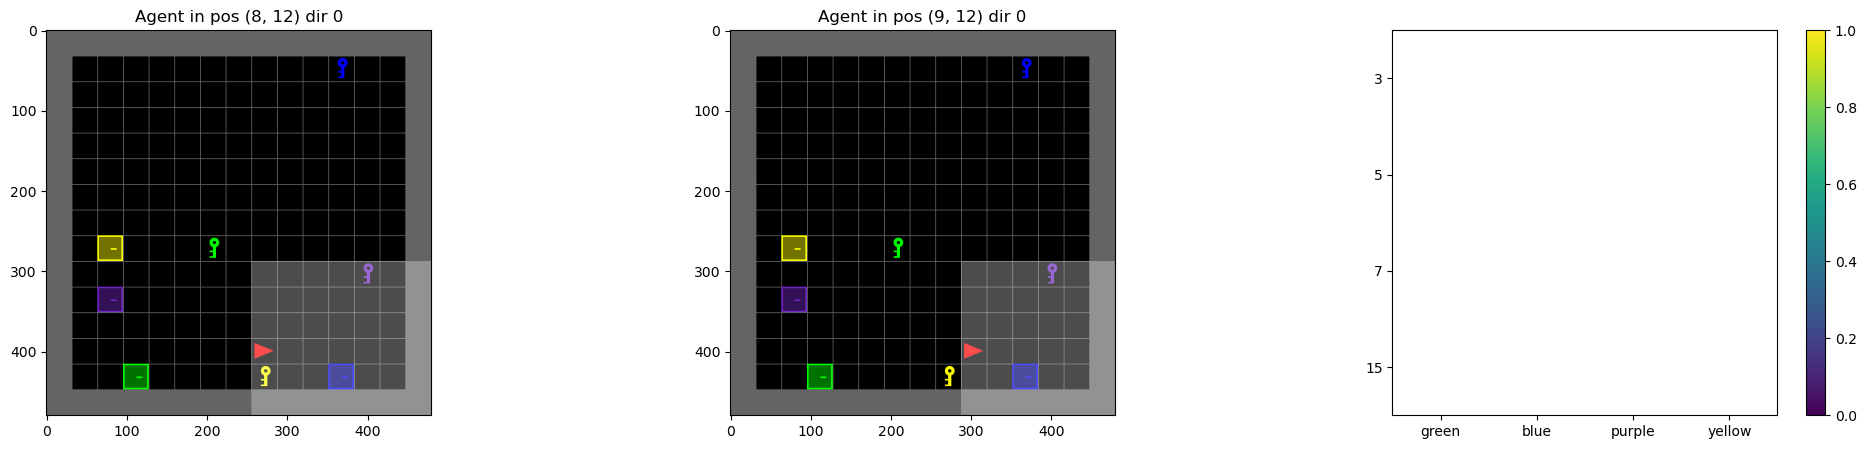

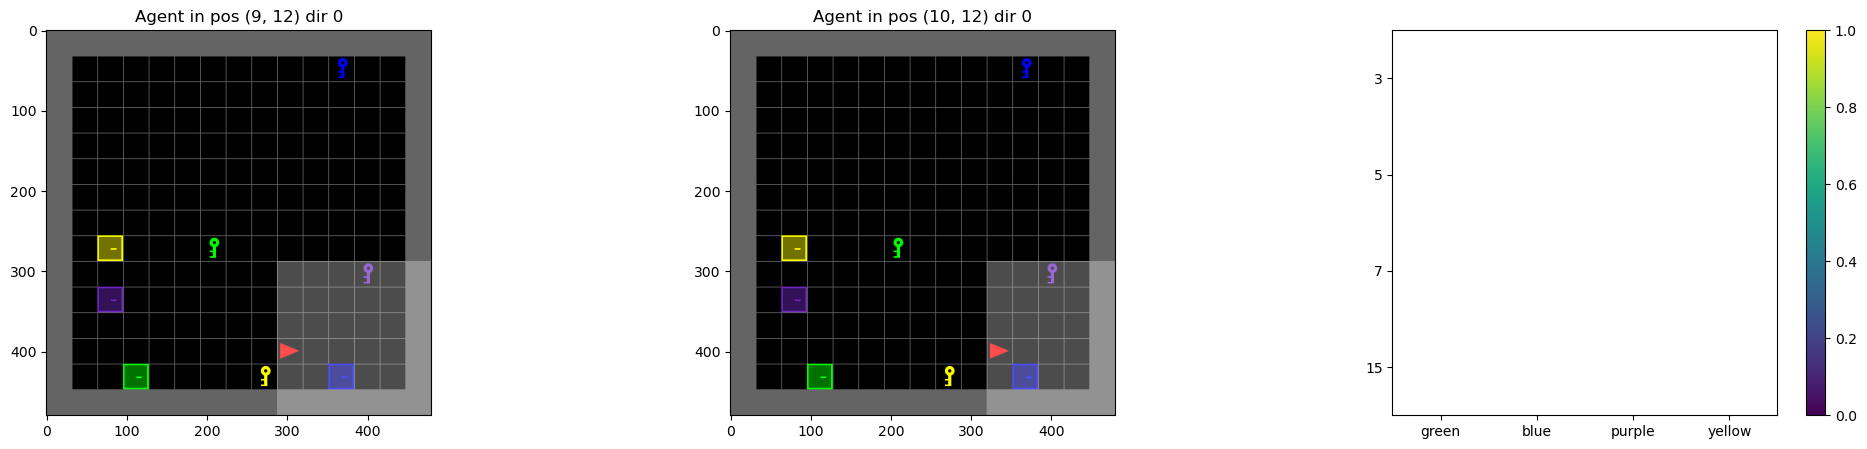

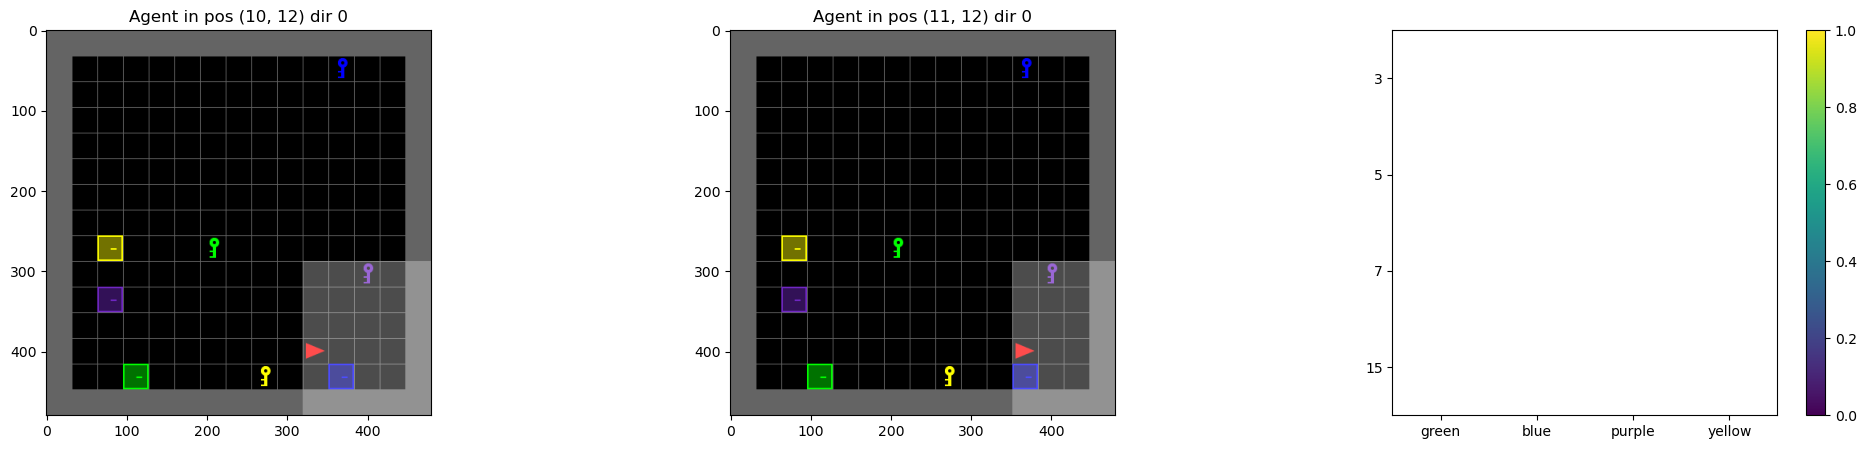

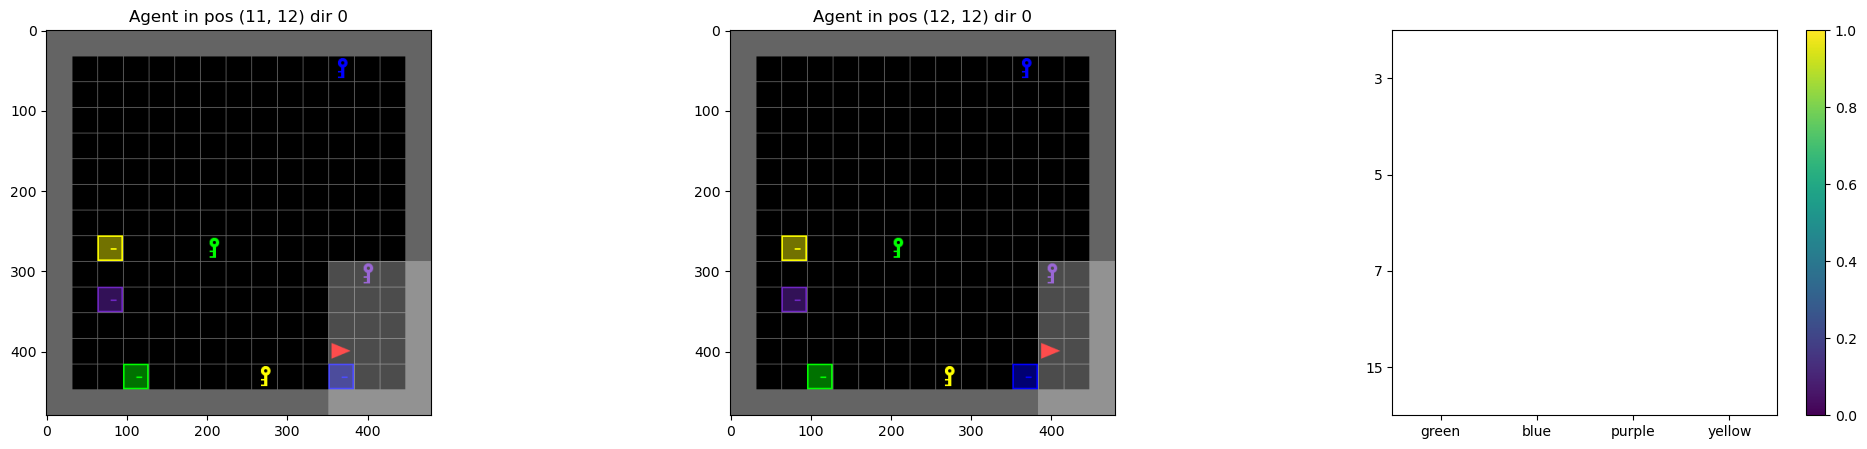

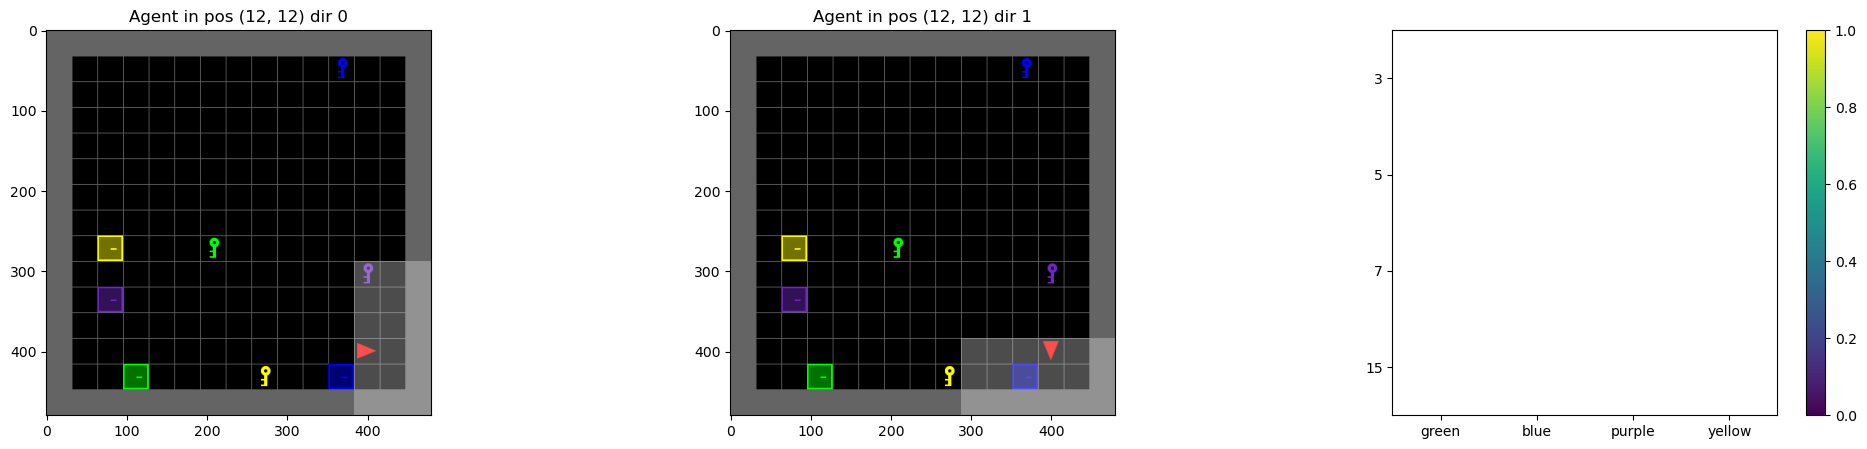

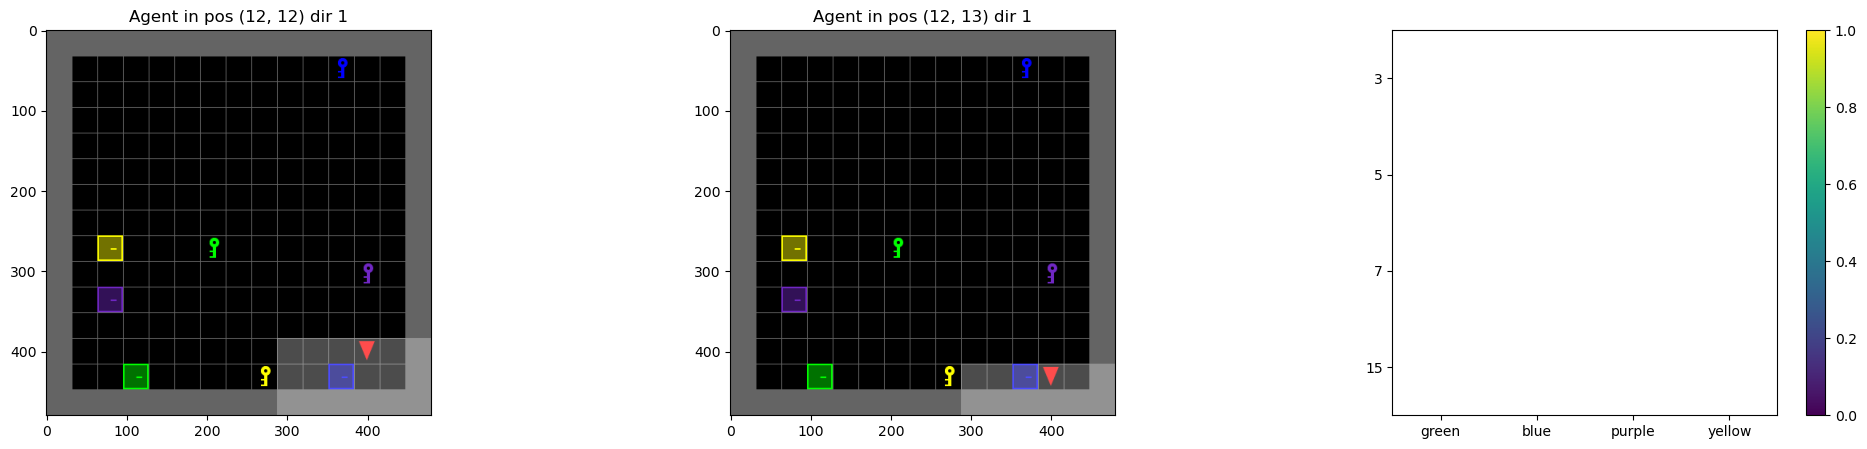

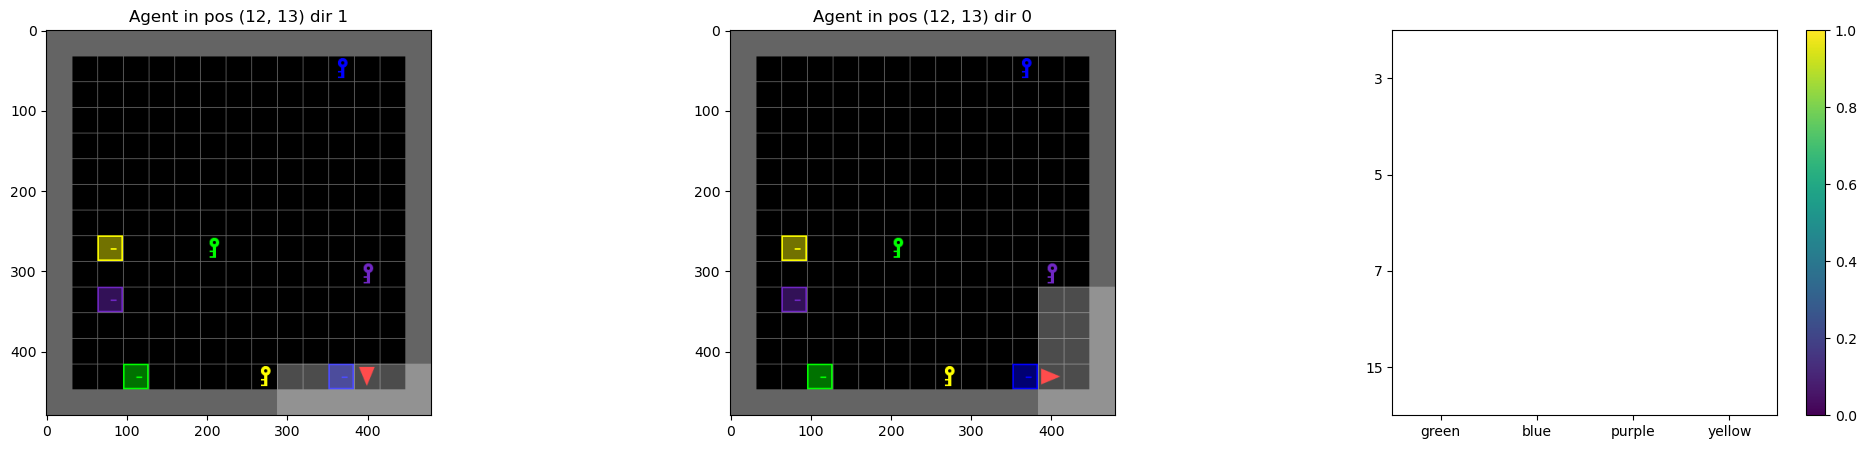

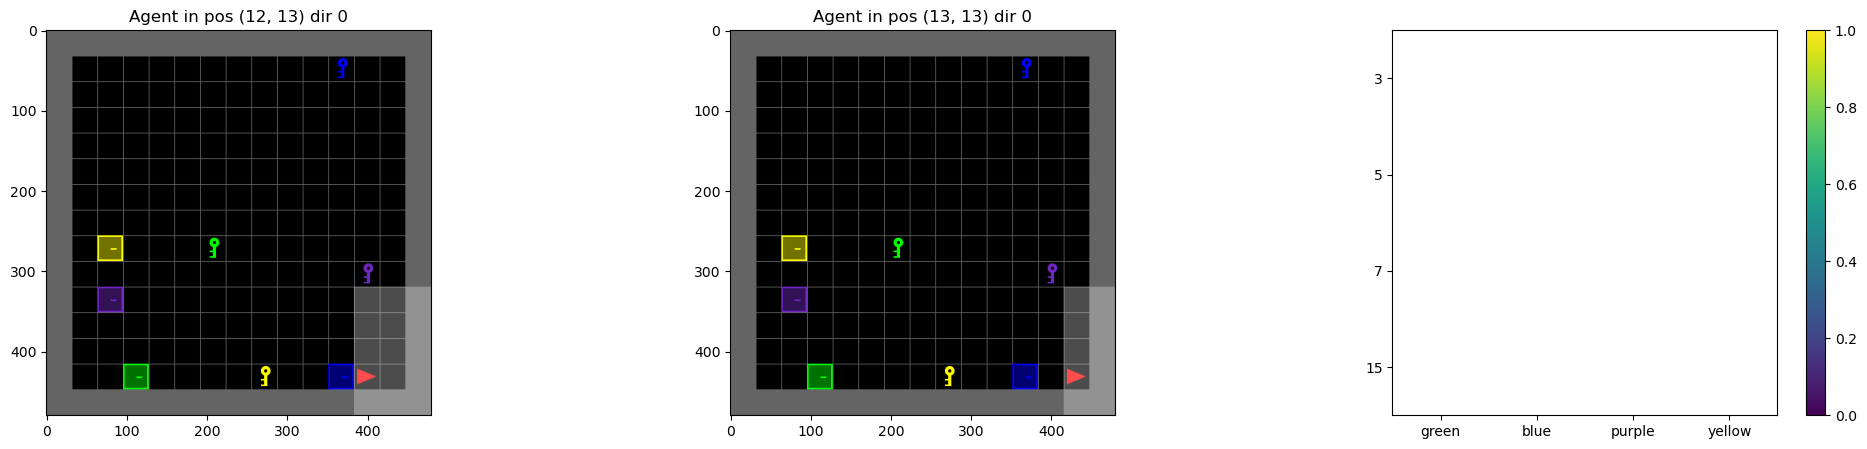

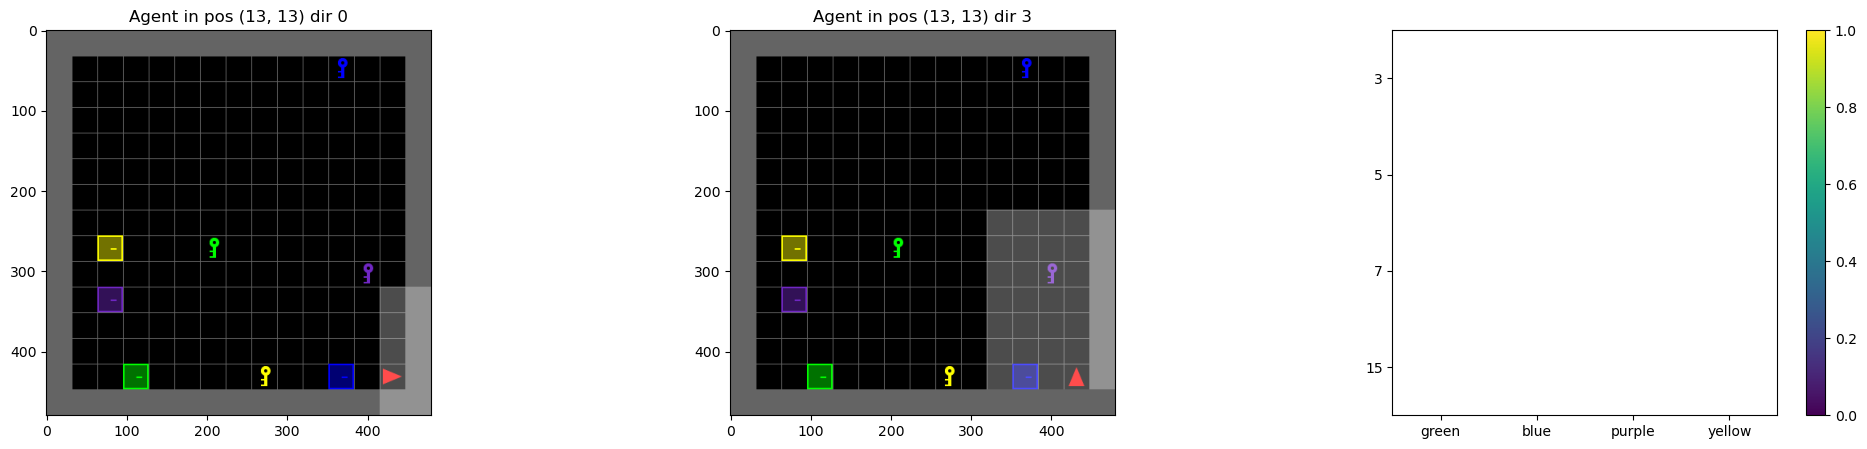

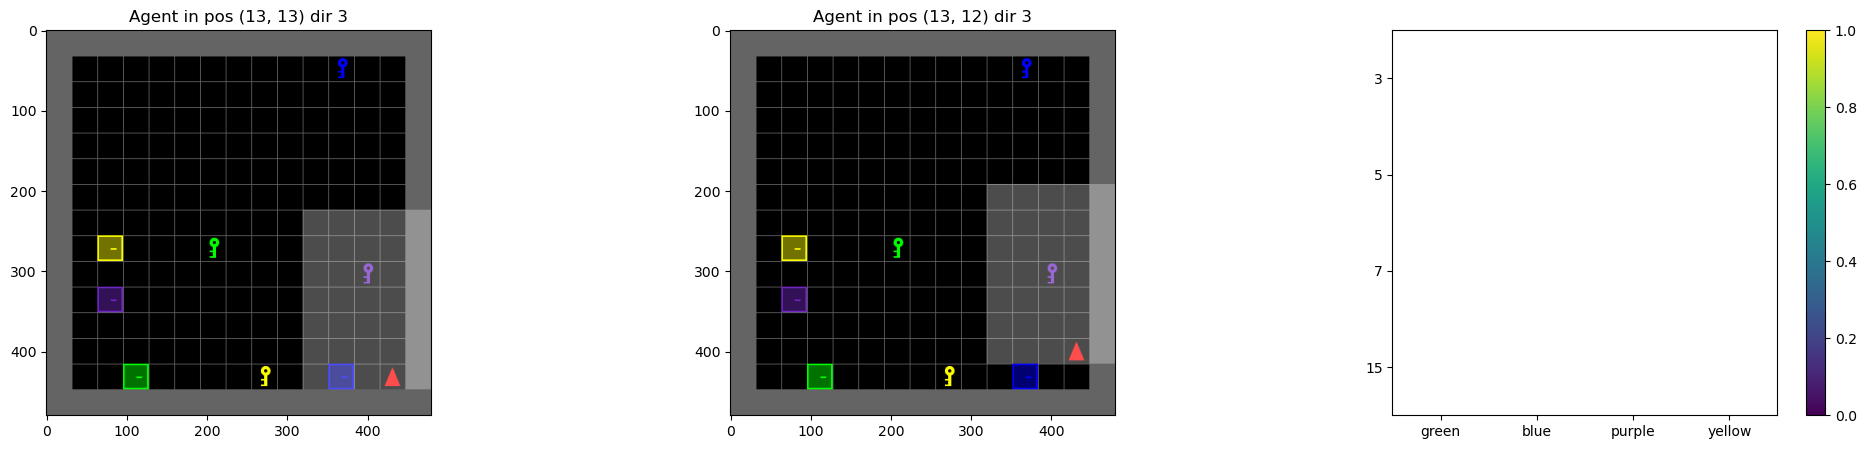

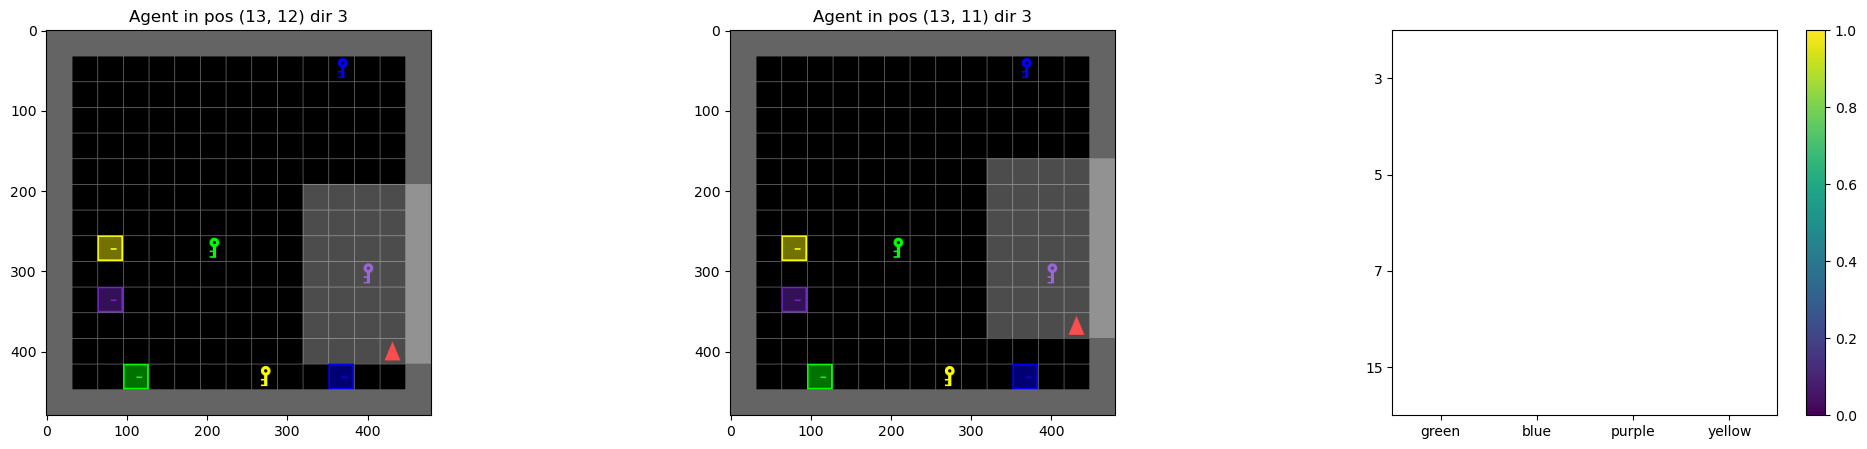

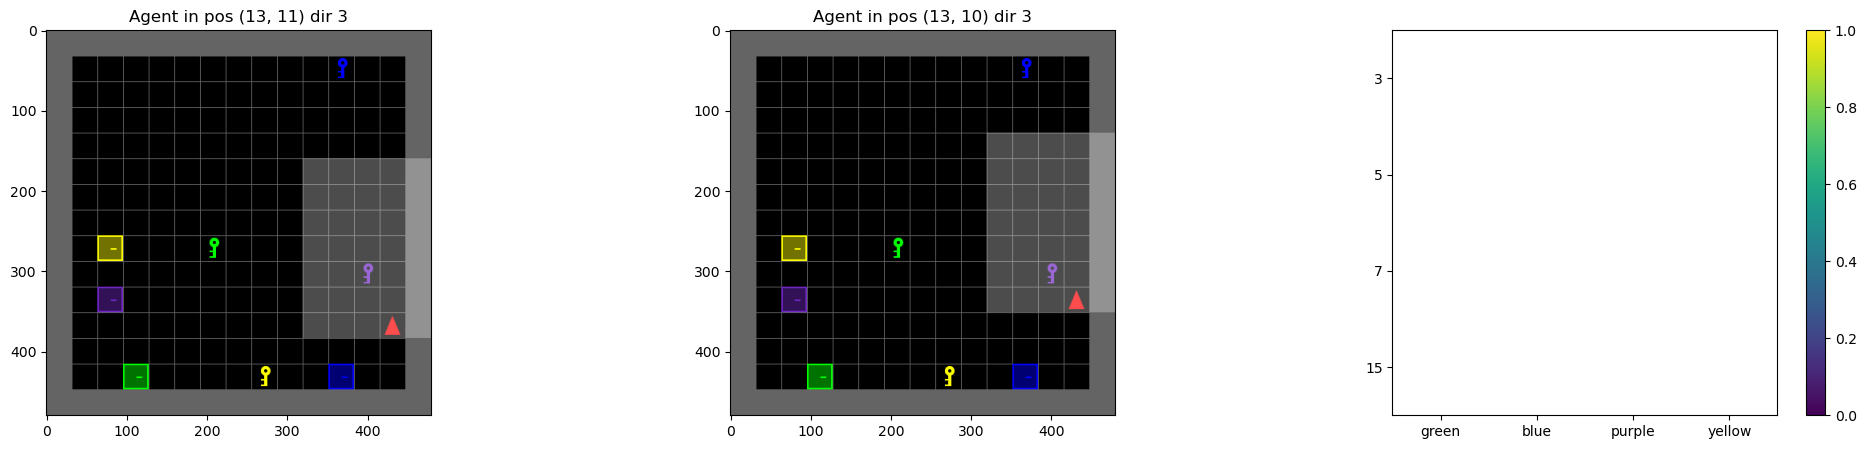

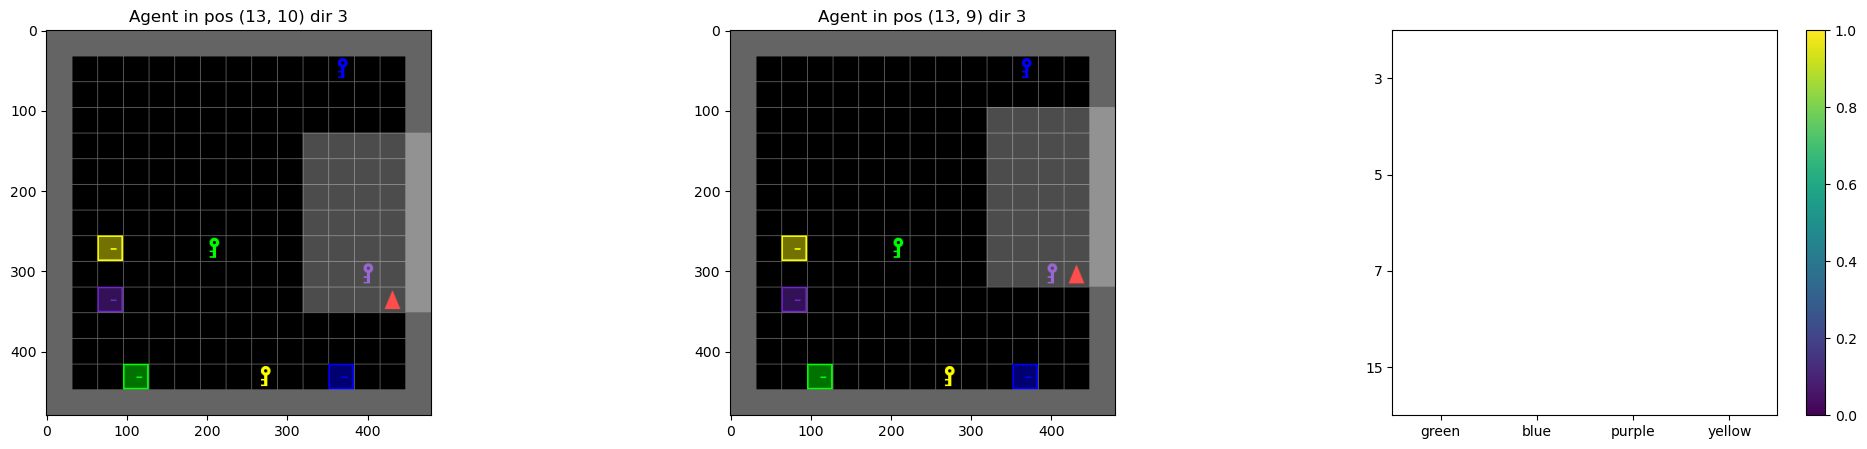

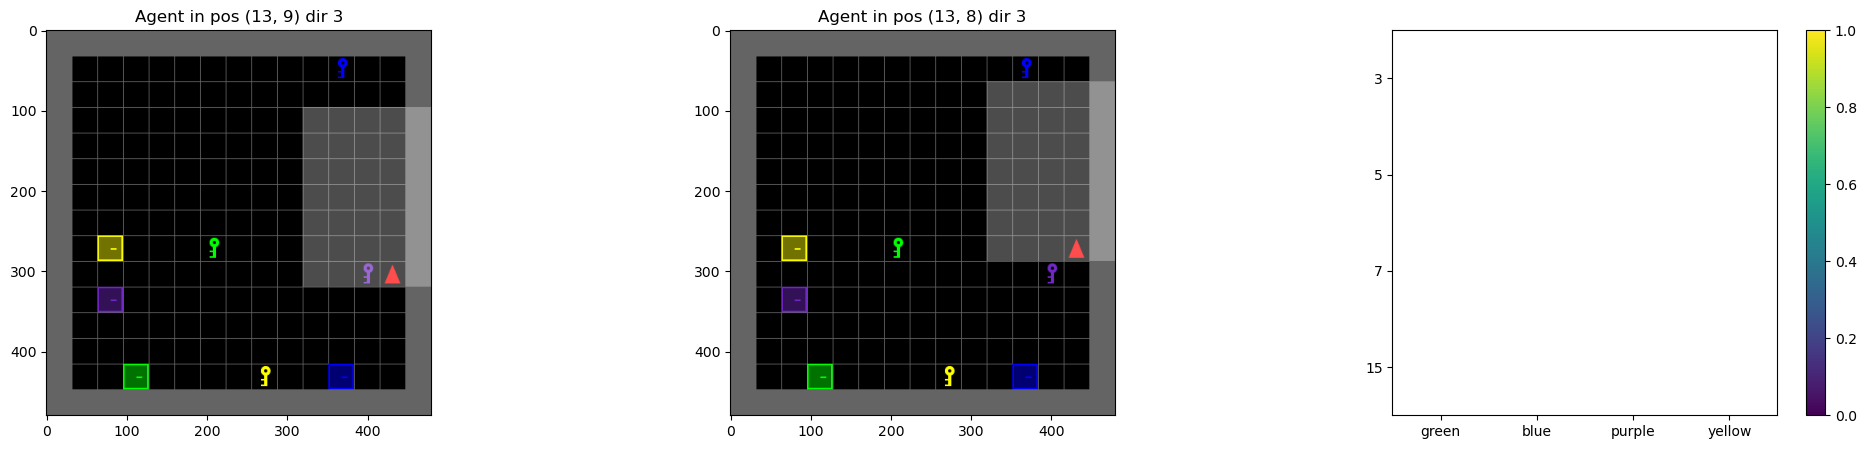

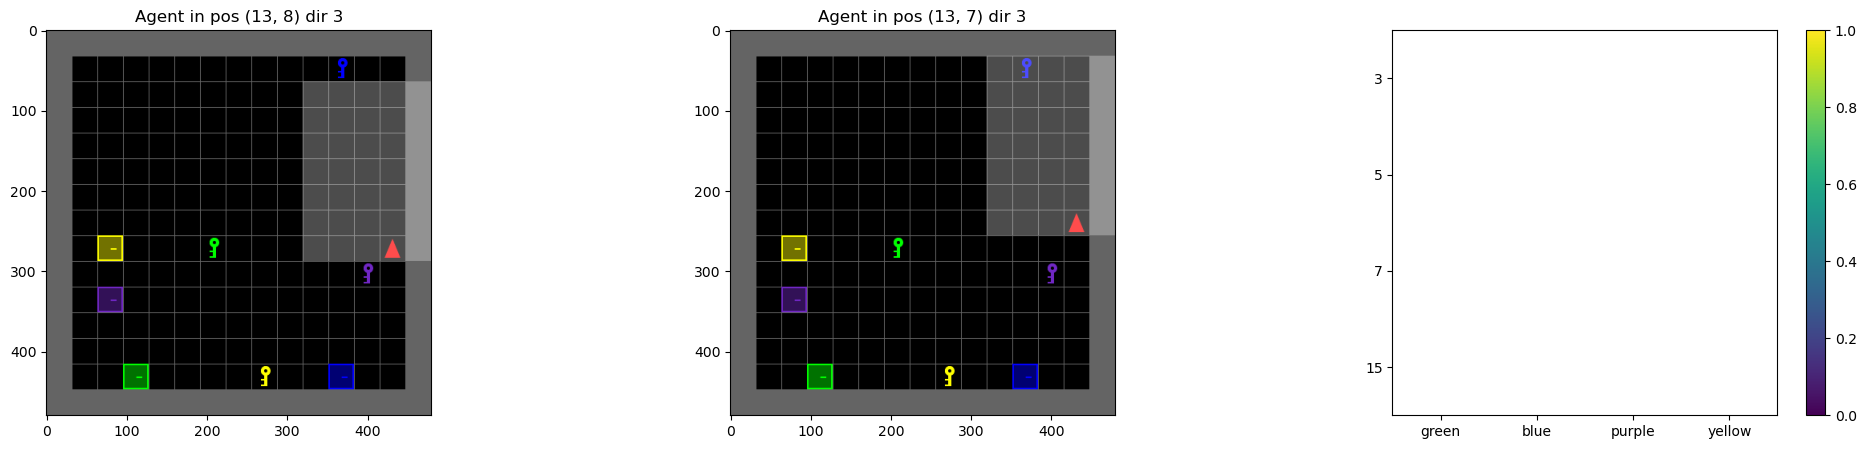

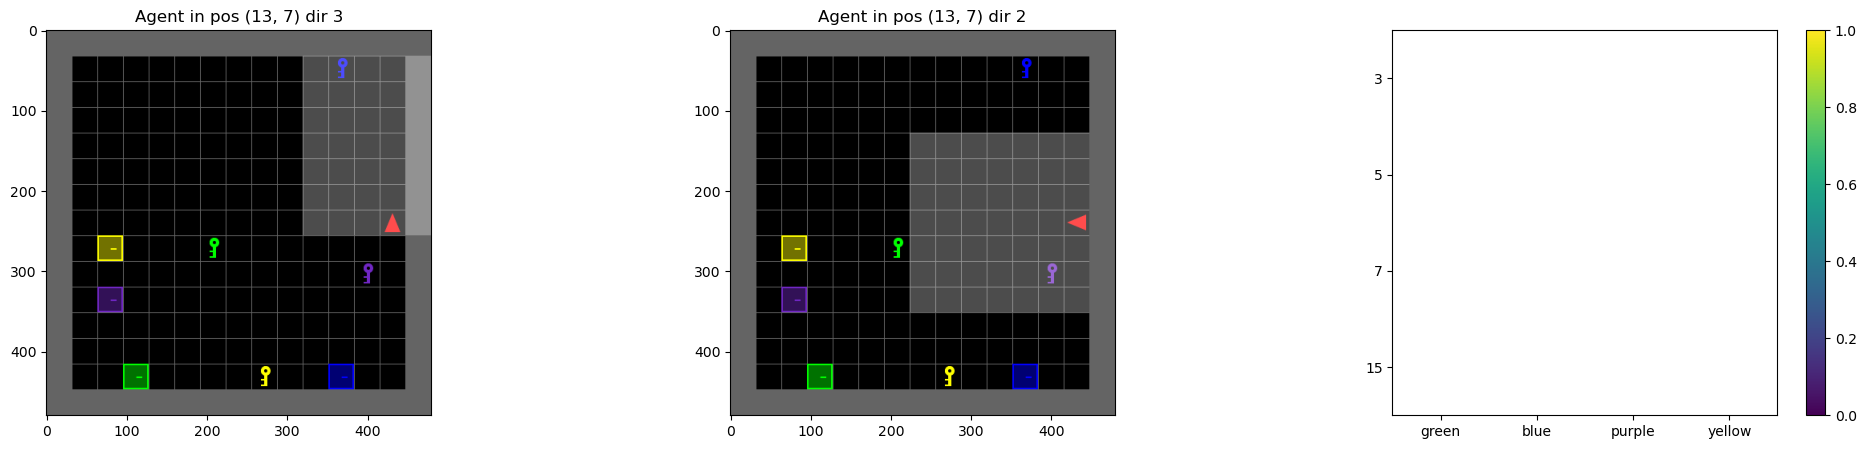

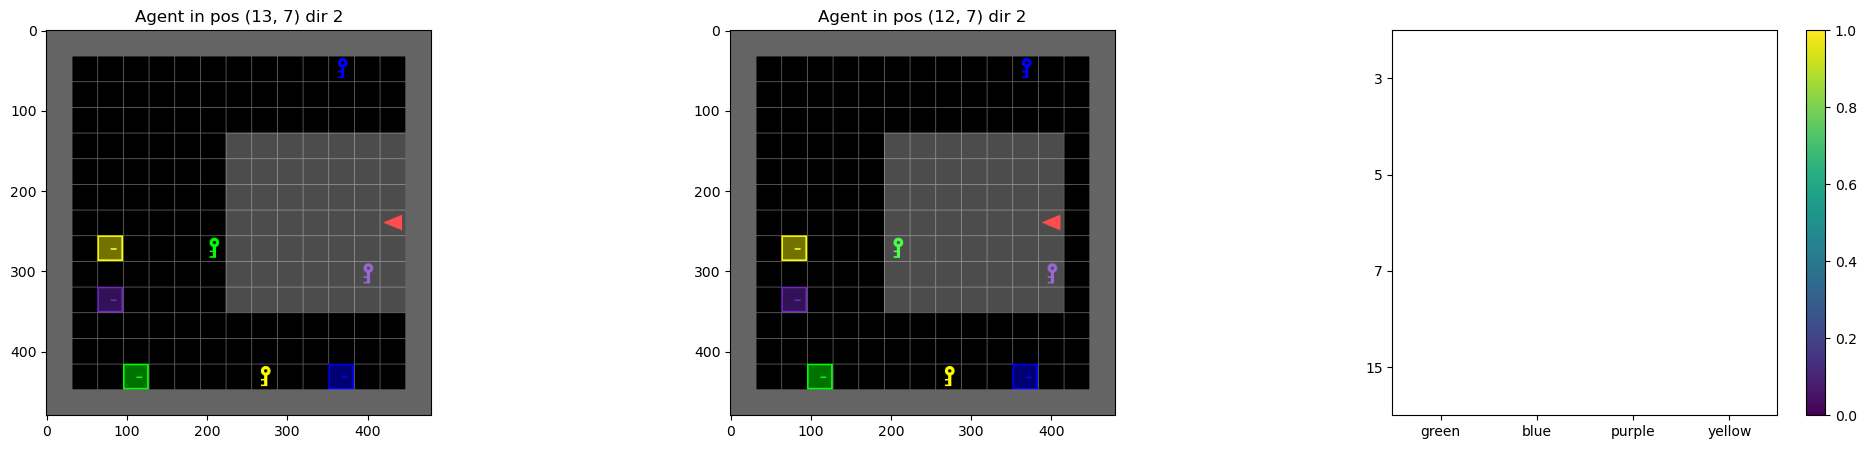

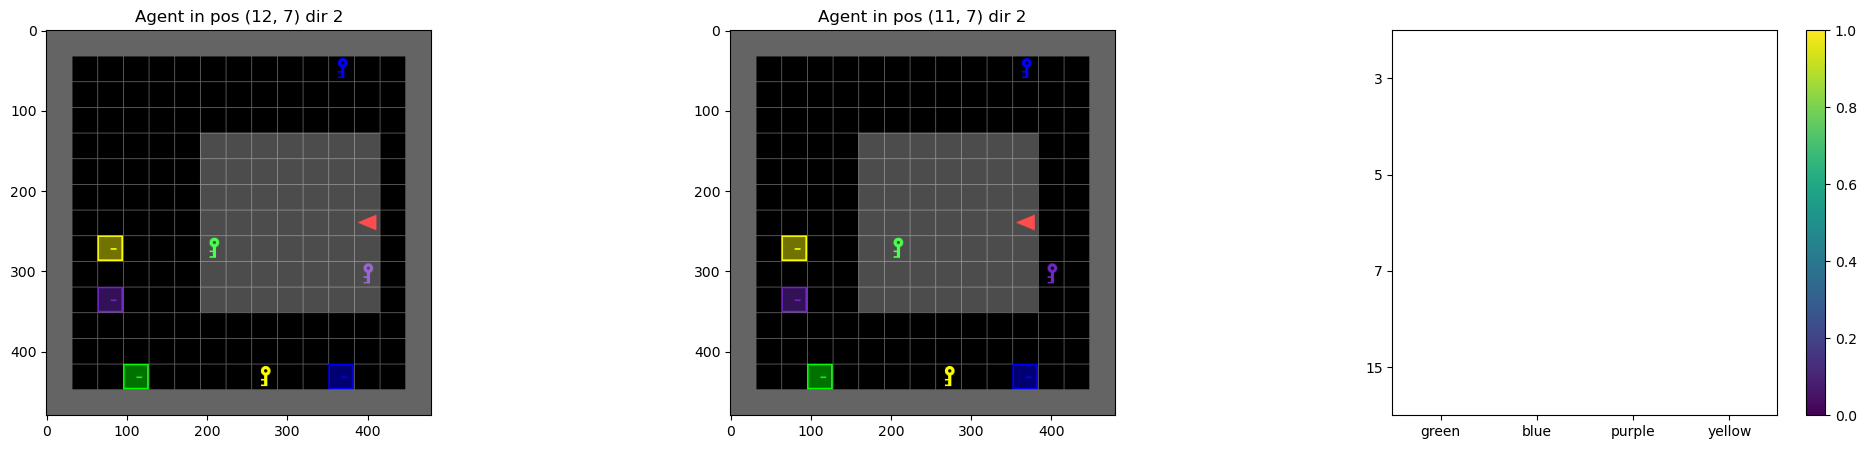

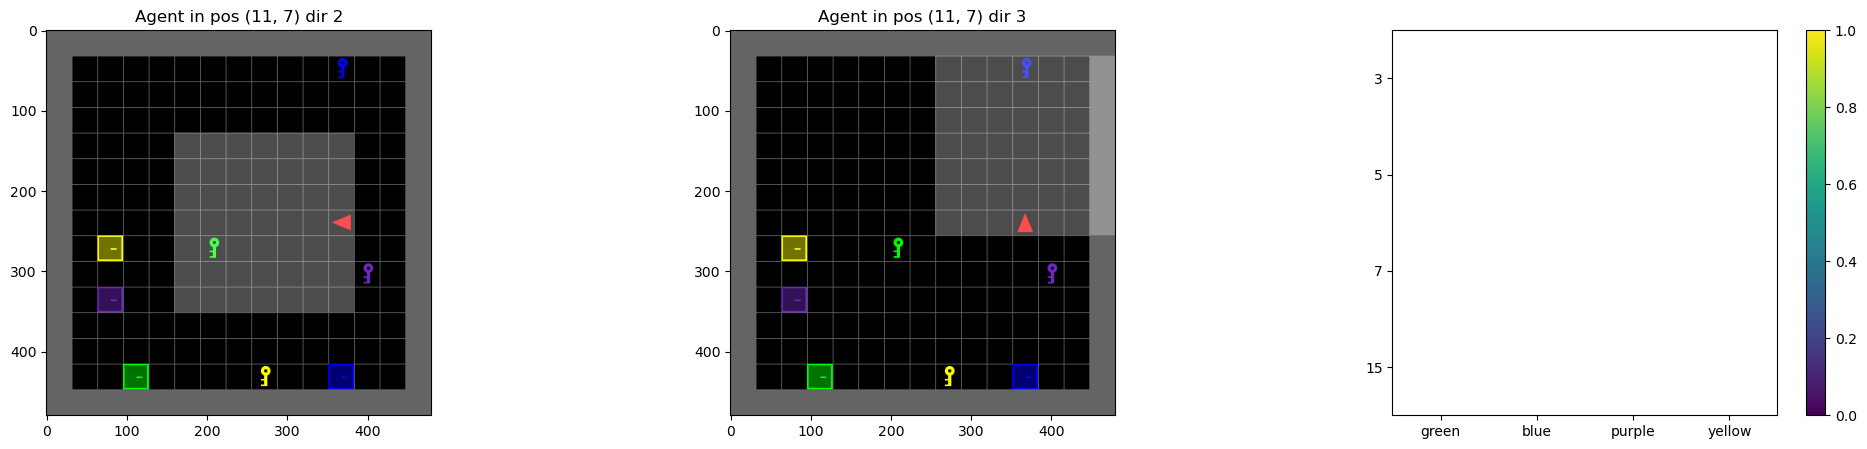

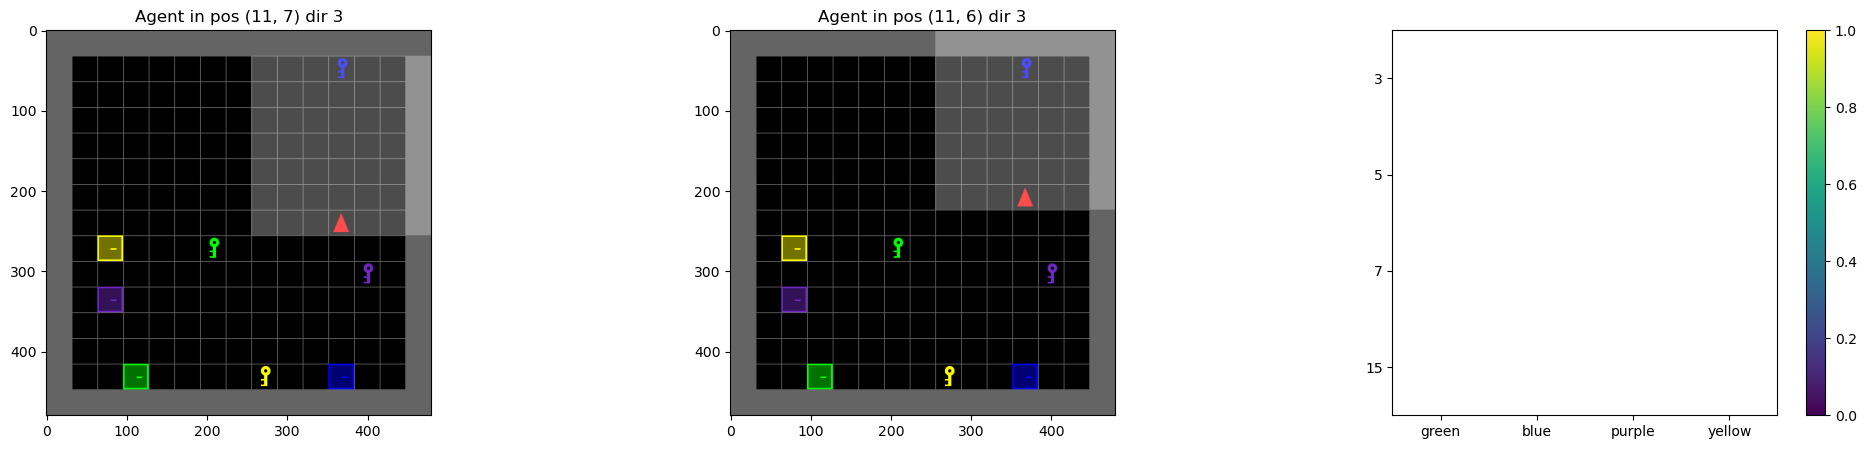

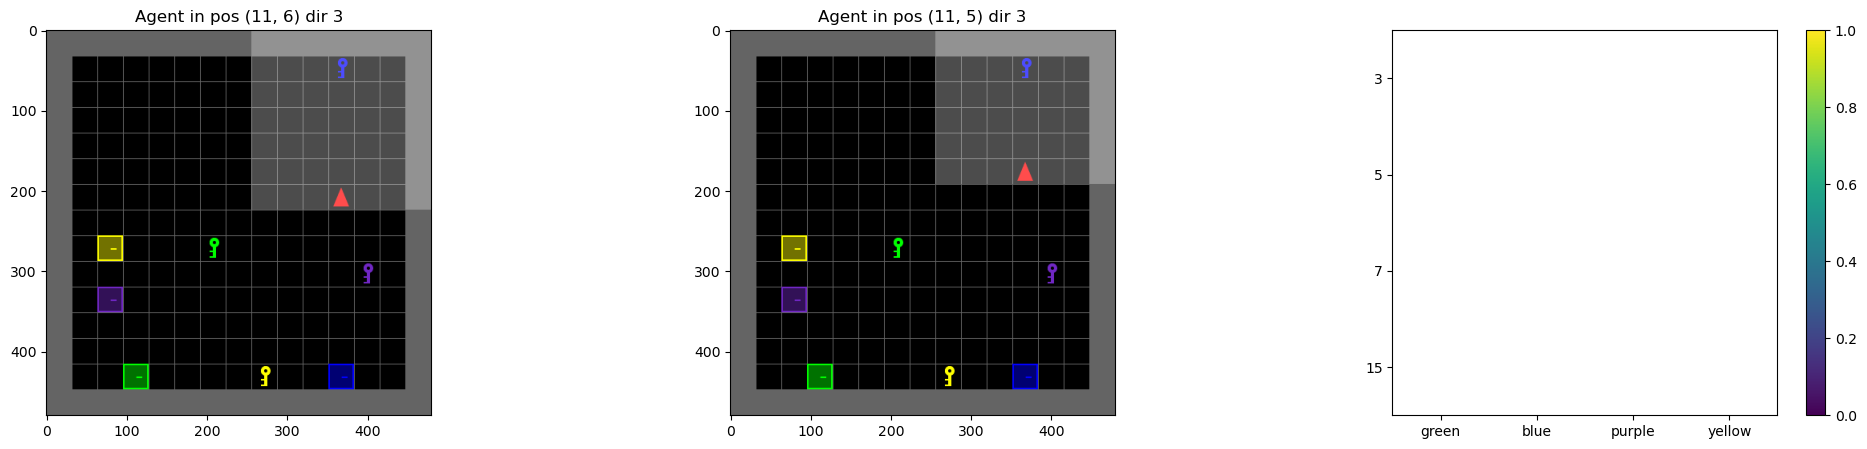

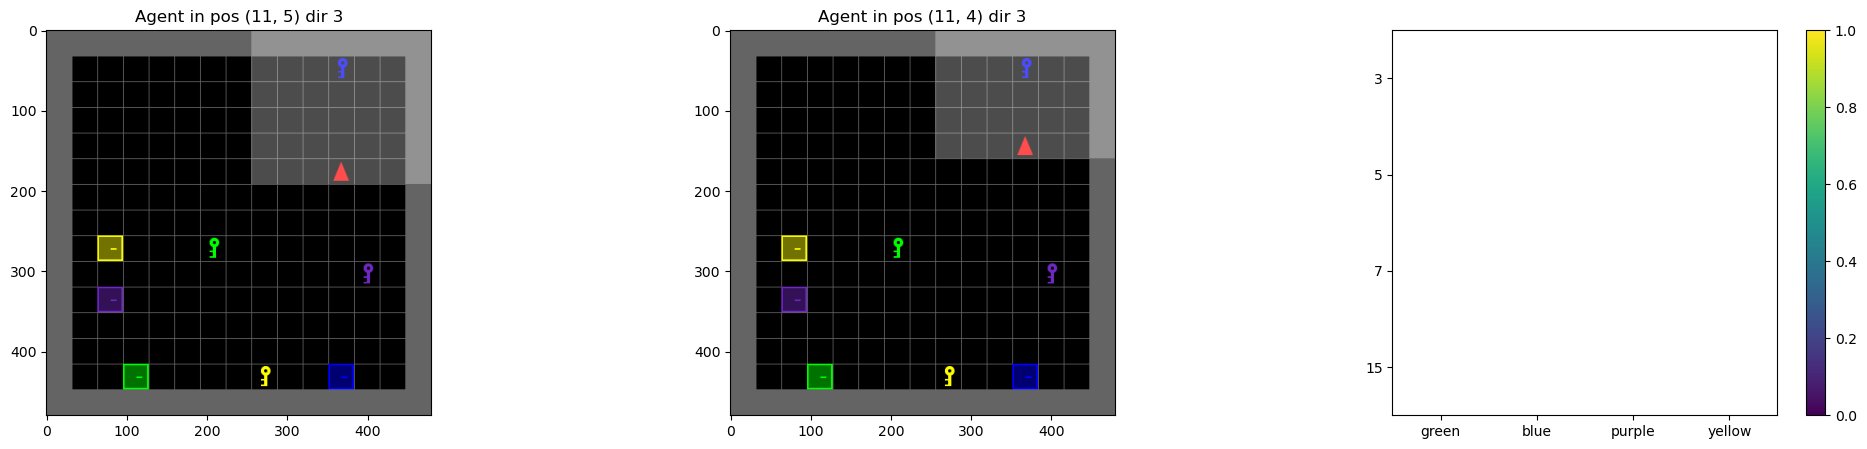

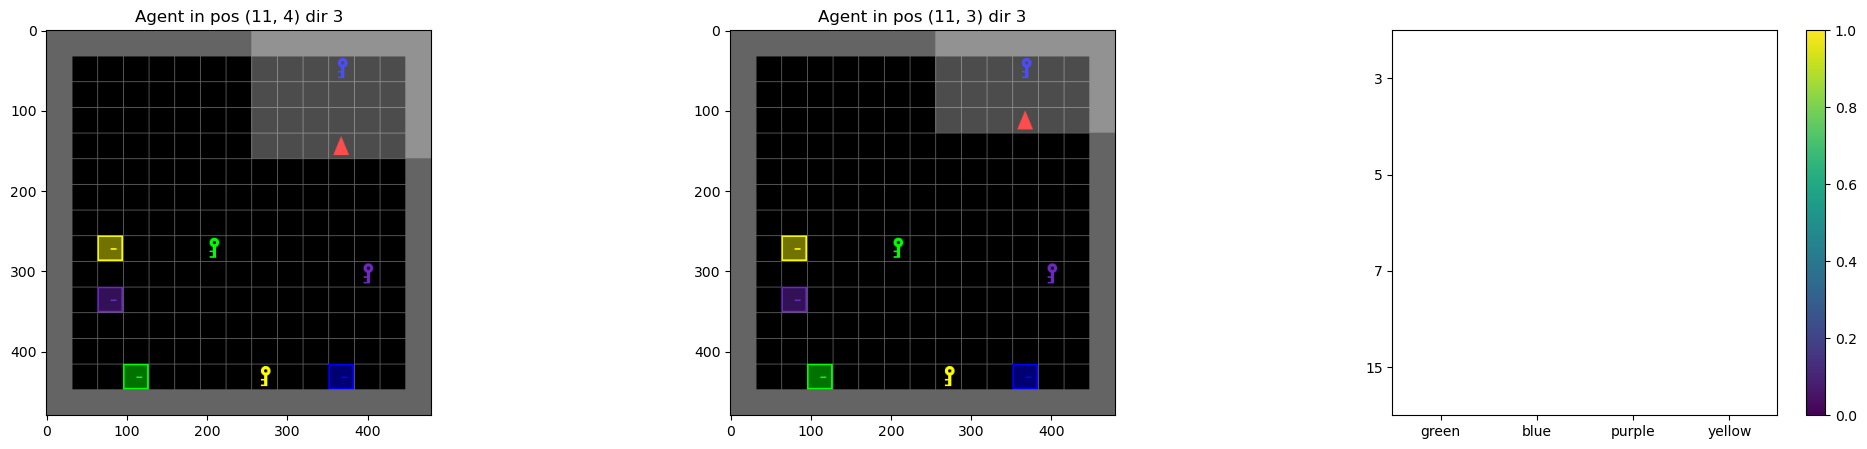

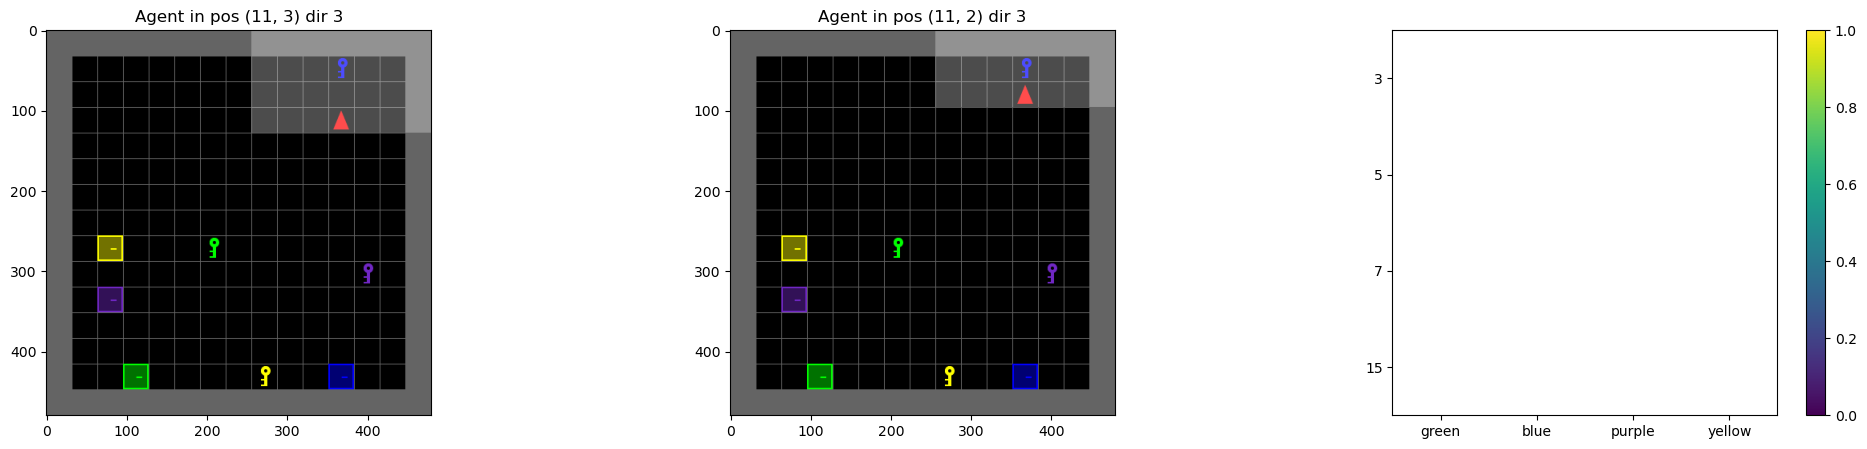

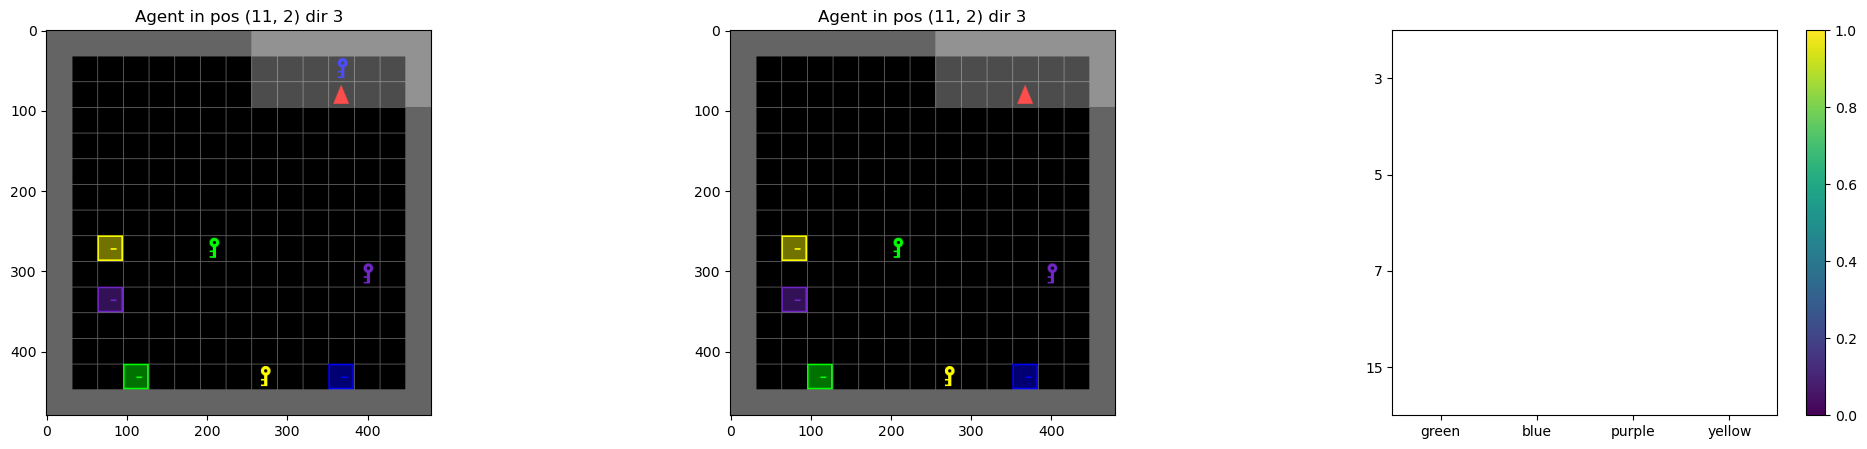

In [1052]:
for ii in range(35):
    fig = plt.figure(figsize=(25,5))
    fig.add_subplot(1,3,1)
    plt.imshow(learner.env.render())
    plt.title('Agent in pos ' + str(learner.env.agent_pos) + ' dir ' + str(learner.env.agent_dir))
    # plt.title("t")

    agent_pos = learner.env.agent_pos
    agent_dir = learner.env.agent_dir
    teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
    traj = learner.play(size=1)

    fig.add_subplot(1,3,2)
    plt.imshow(learner.env.render())
    plt.title('Agent in pos ' + str(learner.env.agent_pos) + ' dir ' + str(learner.env.agent_dir))
    # plt.title("t+1")

    print("True action", traj[0])
    teacher.observe(action=traj[0])

    fig.add_subplot(1,3,3)
    plt.imshow(teacher.beliefs.T, vmin=0., vmax=1.)
    image = plt.imshow(teacher.beliefs.T, vmin=0., vmax=1.)
    plt.colorbar(image)
    plt.xticks(range(0, num_colors), [IDX_TO_COLOR[i] for i in range(1,num_colors + 1)])
    plt.yticks(range(0, len(rf_values)), rf_values)

# ii += 1

### Teacher knowing greedy (getting closer to the goal) when have the information vs exploration otherwise (uniform)

### Display

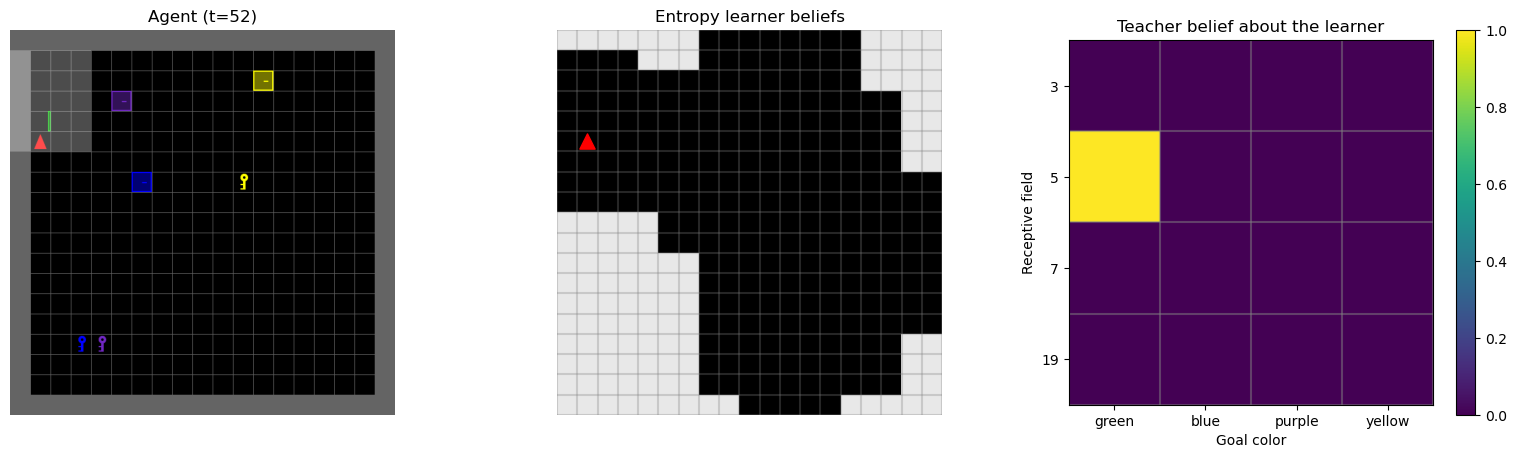

In [14]:
from IPython.display import clear_output
from PIL import Image

GRID_SIZE = 19

receptive_field = 5
goal_color = 0
lambd = 0.1

rf_values_basic = [3, 5, 7]
rf_values = np.array(rf_values_basic + [GRID_SIZE])

learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE) #, save_render=True)
teacher = BayesianTeacher(env=learner.env, lambd=lambd, rf_values=rf_values)

ii = 0
images = []
while not learner.terminated: # and ii < 1:
    
    # Interaction
    agent_pos = learner.env.agent_pos
    agent_dir = learner.env.agent_dir
    teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
    traj = learner.play(size=1)
    teacher.observe(action=traj[0])

    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1,3,1)
    plt.imshow(learner.env.render())
    plt.title(f'Agent (t={ii})')
    plt.axis('off')

    fig.add_subplot(1,3,2)
    learner_beliefs_image = Shannon_entropy(learner.beliefs, axis=2) / (Shannon_entropy( 1 / 4 * np.ones(4)) + 0.2)
    image = plt.imshow(learner_beliefs_image.T, vmin=0., vmax=1., cmap='gray')
    plot_agent(teacher.env.agent_pos, teacher.env.agent_dir)
    plot_grid(-.5, GRID_SIZE + 1, GRID_SIZE - 0.5, alpha=0.3)
    # plt.colorbar(image)
    plt.title('Entropy learner beliefs')
    plt.axis('off')

    fig.add_subplot(1, 3, 3)
    plt.imshow(teacher.beliefs.T, vmin=0., vmax=1.)
    image = plt.imshow(teacher.beliefs.T, vmin=0., vmax=1.)
    plt.colorbar(image)
    plt.xticks(range(0, num_colors), [IDX_TO_COLOR[i] for i in range(1, num_colors + 1)])
    plt.yticks(range(0, len(rf_values)), rf_values)
    plt.title('Teacher belief about the learner')
    plt.ylabel('Receptive field')
    plt.xlabel('Goal color')
    plot_grid(-.5, 5, 3.5)
    # plt.grid(True, which='major', linewidth=0.5)

    canvas = FigureCanvasAgg(fig)
    canvas.draw()

    # Get the image buffer as a PIL image
    pil_image = Image.frombytes('RGB', canvas.get_width_height(), canvas.tostring_rgb())
    images.append(pil_image)

    clear_output(wait=True)
    plt.show(fig)

    ii += 1

##### Saving LOG and rendering

In [32]:
filename = "./outputs_rendering/bug/LOG_teacher.csv"

with open(filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)

    for sentence in teacher.LOG:
        writer.writerow([sentence])

In [33]:
filename = "./outputs_rendering/bug/LOG_learner.csv"

with open(filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)

    for sentence in learner.LOG:
        writer.writerow([sentence])

In [34]:
gif_file = f"./outputs_rendering/bug/rendering_rf_{receptive_field}.gif"
images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

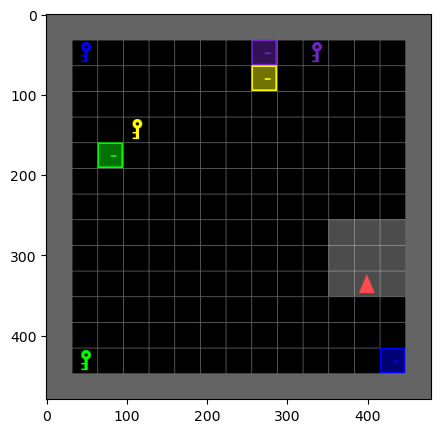

In [115]:
fig = plt.figure(figsize=(15,5))
plt.imshow(learner.render_frames[12])

##### Display computed distance map

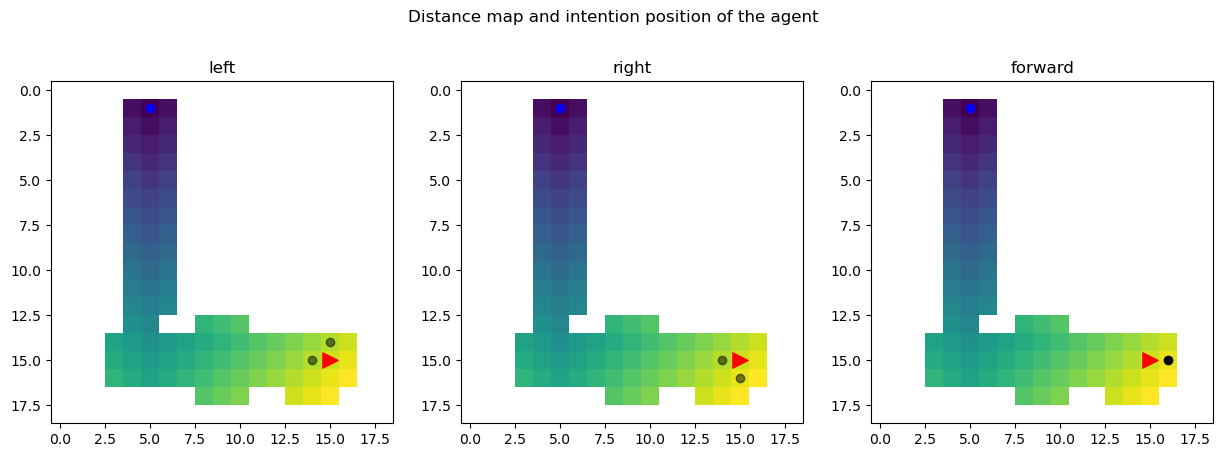

In [43]:
rf_idx = 0
goal_color =  0

fig = plt.figure(figsize=(15,5))
subtitles = ['left', 'right', 'forward']

goal_pos = np.where(teacher.learner_beliefs[rf_idx, :, :, 2 + goal_color * 2] == 1)
for action in range(3):
    fig.add_subplot(1,3,action + 1)

    agent_pos = (15, 15)
    agent_dir = 0

    plt.imshow(teacher.distance_goal[rf_idx, goal_color].T)
    plot_agent(agent_pos, agent_dir)

    if action == 2:
        next_dir = agent_dir
        next_pos = agent_pos + DIR_TO_VEC[next_dir]
        plt.scatter(next_pos[0], next_pos[1], c='k')
    # If known obstacle in front don't considerer intention to move when turn left/right
    elif action in [0, 1]: # Turn left or right
        if action == 0:
            next_dir = (agent_dir - 1) % 4
            next_next_dir = (agent_dir - 2) % 4
        elif action == 1:
            next_dir = (agent_dir + 1) % 4
            next_next_dir = (agent_dir + 2) % 4            
    
        next_pos = agent_pos + DIR_TO_VEC[next_dir] # Turn 
        next_next_pos = agent_pos + DIR_TO_VEC[next_next_dir] # U-turn
        plt.scatter(next_next_pos[0], next_next_pos[1], c='k', alpha=0.5)
        plt.scatter(next_pos[0], next_pos[1], c='k', alpha=0.5)

    plt.scatter(goal_pos[0], goal_pos[1], c='b')
    plt.title(subtitles[action])

fig.suptitle('Distance map and intention position of the agent');

### Stats 

In [5]:
grid_size_values = [11, 13, 15, 17, 19, 21]
lamd_values = [0.1, 0.5, 0.8, 1., 1.2, 2., 3.]

In [7]:
N = 200
rf_values_basic = [3, 5, 7]

for lambd in lamd_values:

    DICT = {}

    # Progress bar
    print(f'Progress lambda={lambd}:', end='\n')
    pbar = progressbar.ProgressBar(maxval=len(grid_size_values) * len(rf_values) * num_colors * N).start()
    nn = 0

    for GRID_SIZE in grid_size_values:
        dict = {}

        rf_values = np.array(rf_values_basic + [GRID_SIZE])

        for rf_idx,receptive_field in enumerate(rf_values):
            dict[receptive_field] = {}
            for goal_color in range(num_colors):
                dict[receptive_field][goal_color] = {}

                dict[receptive_field][goal_color]['accuracy'] = {}
                dict[receptive_field][goal_color]['accuracy']['goal'] = []
                dict[receptive_field][goal_color]['accuracy']['rf'] = []

                dict[receptive_field][goal_color]['length'] = []
                dict[receptive_field][goal_color]['beliefs'] = []
                for _ in range(N):
                    learner = BayesianLearner(goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE)
                    teacher = BayesianTeacher(env=learner.env, rf_values=rf_values,lambd=lambd)

                    ii = 0
                    while not learner.terminated: # and ii < 1:
                        
                        # Interaction
                        agent_pos = learner.env.agent_pos
                        agent_dir = learner.env.agent_dir
                        teacher.update_knowledge(learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii)
                        traj = learner.play(size=1)
                        teacher.observe(action=traj[0])

                        assert(not np.isnan(teacher.beliefs[0, 0]))

                        ii += 1

                    argmax_set = np.where(teacher.beliefs == np.max(teacher.beliefs))
                    argmax_idx = np.random.choice(len(argmax_set[0]))
                    argmax = np.array([argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]])

                    dict[receptive_field][goal_color]['accuracy']['goal'].append(goal_color == argmax[0])
                    dict[receptive_field][goal_color]['accuracy']['rf'].append(rf_idx == argmax[1])
                    dict[receptive_field][goal_color]['length'].append(ii)
                    dict[receptive_field][goal_color]['beliefs'].append(teacher.beliefs)
                    
                    # Progress bar
                    nn += 1
                    pbar.update(nn)

        DICT[GRID_SIZE] = dict
        
        # Save dict
        with open(f'./stats/lambda_{lambd}/stats_outputs_lambd_{lambd}.pickle', 'wb') as f:
            pickle.dump(DICT, f)



Progress lambda=0.1:


#### Display ToM model analysis

In [28]:
# Parameters for display
GRID_SIZE = 19
lambd = 0.8

rf_values = np.array(rf_values_basic + [GRID_SIZE])

with open(f'./stats/lambda_{lambd}/stats_outputs_lambd_{lambd}.pickle', 'rb') as f:
    DICT = pickle.load(f)
dict = DICT[GRID_SIZE]

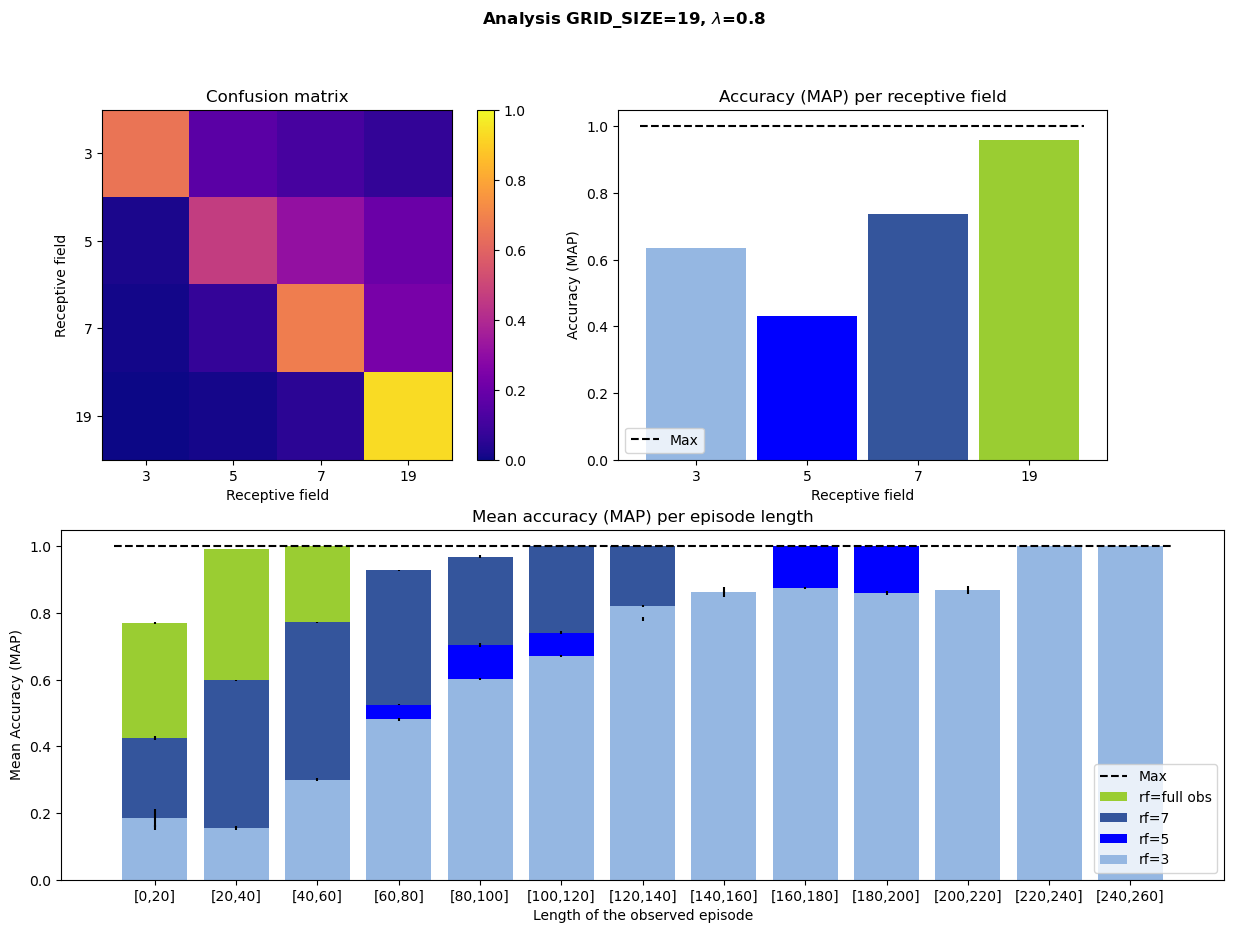

In [29]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 0.1])

# First row, first column
ax1 = plt.subplot(gs[0, 0])
confusion_matrix = np.zeros((len(rf_values), len(rf_values)))
for rf_idx,receptive_field in enumerate(rf_values):
    for goal_color in range(num_colors):
        
        for beliefs in dict[receptive_field][goal_color]['beliefs']:
                confusion_matrix[rf_idx, :] += beliefs[goal_color, :]

confusion_matrix /= num_colors * N
plt.imshow(confusion_matrix, vmin=0., vmax=1.)
im = plt.imshow(confusion_matrix, vmin=0., vmax=1., cmap='plasma')
plt.colorbar(im)
plt.title('Confusion matrix')
plt.ylabel('Receptive field')
plt.xlabel('Receptive field')
plt.xticks(range(0, len(rf_values)), rf_values)
plt.yticks(range(0, len(rf_values)), rf_values)

# First row, second column
ax2 = plt.subplot(gs[0, 1])
colors = [np.array([149, 183, 226]) / 255, 'blue', np.array([52, 85, 156]) / 255, 'yellowgreen']
mean_all = np.zeros(len(rf_values))
std_all = np.zeros(len(rf_values))
for rf_idx, rf in enumerate(rf_values):
    all_acc = []
    for goal_color in range(num_colors):
        all_acc += dict[rf][goal_color]['accuracy']['rf']
    mean_all[rf_idx] = np.mean(all_acc)
    std_all[rf_idx] = 1.96 * np.std(all_acc) / (4 * N)

plt.bar(np.array(rf_values).astype(str), mean_all, width=.9, yerr=std_all, color=colors)
plt.plot([-0.5, len(rf_values)-0.5], [1, 1], c='k', label='Max', ls='--')
plt.ylabel('Accuracy (MAP)')
plt.xlabel('Receptive field')
plt.legend()
plt.title('Accuracy (MAP) per receptive field')

ax3 = plt.subplot(gs[1, :])
plot_error_episode_length(colors=colors, rf_values=rf_values, num_colors=num_colors, dict=dict)

# plt.tight_layout()

fig.suptitle(f'Analysis GRID_SIZE={GRID_SIZE}, $\lambda$={lambd}', fontweight='bold')

fig.savefig(f'./stats/lambda_{lambd}/analysis_gridsize_{GRID_SIZE}.png');

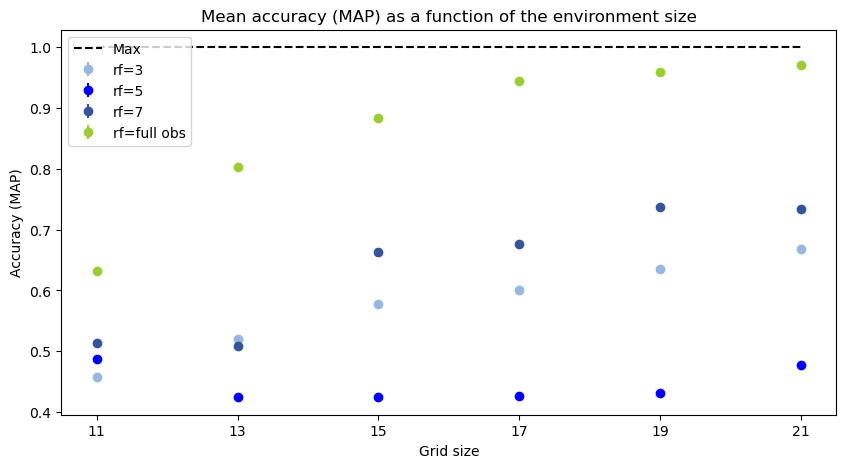

In [30]:
fig = plt.figure(figsize=(10,5))

for ii,GRID_SIZE in enumerate(grid_size_values):
    dict = DICT[GRID_SIZE]
    rf_values = np.array(rf_values_basic + [GRID_SIZE])
    labels = np.concatenate((np.array(rf_values)[:-1], np.array(['full obs'])))
    
    for rf_idx, rf in enumerate(rf_values):
        all_acc = []
        for goal_color in range(num_colors):
            all_acc += dict[rf][goal_color]['accuracy']['rf']
        if ii == 5:
            plt.errorbar(ii, np.mean(all_acc), yerr=1.96 * np.std(all_acc) / (4 * N), color=colors[rf_idx], fmt="o", label=f'rf={labels[rf_idx]}')
        else:
            plt.errorbar(ii, np.mean(all_acc), yerr=1.96 * np.std(all_acc) / (4 * N), color=colors[rf_idx], fmt="o")
plt.plot([0, 5], [1, 1], label='Max', ls='--', c='k')
plt.xticks(np.arange(len(grid_size_values)), grid_size_values)
plt.xlabel('Grid size')
plt.ylabel('Accuracy (MAP)')
plt.title('Mean accuracy (MAP) as a function of the environment size')
plt.legend(loc=2)

fig.savefig(f'./stats/lambda_{lambd}/all_acc_lambda_{lambd}.png');